В якості домашнього завдання вам пропонується створити нейронну мережу за допомогою механізмів Keras, яка буде класифікувати товари із датасету fasion_mnist.


Вам належить запропонувати свою власну архітектуру мережі. Точність найнаївнішої, але адекватної нейромережі становить приблизно 91%. Точність вашої моделі повинна бути не нижчою за цей показник. Щоб досягти таких значень вам знадобиться поекспериментувати з гіперпараметрами мережі:


**кількість шарів;
кількість нейронів;
функції активації;
кількість епох;
розмір батчу;
вибір оптимізатора;
різні техніки регуляризації**

Використайте вивчені техніки виявлення проблем навчання нейронної мережі, і потім поекспериментуйте.

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import fashion_mnist

import matplotlib.pyplot as plt

from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras import optimizers
from keras import losses
from keras import metrics
from tensorflow.keras.callbacks import EarlyStopping
import copy

In [2]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0

4422102/4422102 [==============================] - 1s 0us/step


**Перевірка датасету**

In [22]:
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)


(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


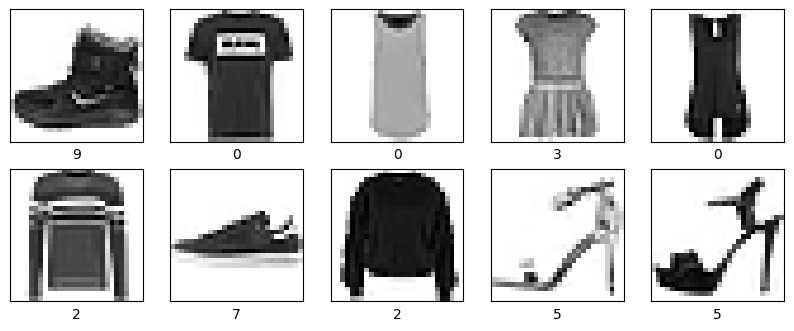

In [23]:
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(train_labels[i])
plt.show()

**Функція відображення графіків втрат і точності на наборах даних**

In [3]:
def plot_history(history):
    train_loss = history.history['loss']
    train_acc = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_acc = history.history['val_accuracy']

    epochs = range(1, len(train_loss) + 1)

    plt.plot(epochs, train_loss, 'r', label='Втрати на тренувальному наборі')
    plt.plot(epochs, val_loss, 'b', label='Втрати на тестовому наборі')
    plt.plot(epochs, train_acc, 'g', label='Точність на тренувальному наборі')
    plt.plot(epochs, val_acc, 'y', label='Точність на тестовому наборі')

    plt.title('Втрати та точність на тренувальному та тестовому наборі')
    plt.xlabel('Епоха')
    plt.ylabel('Метрики')
    plt.legend()
    plt.show()

**Функція пошуку оптимальних параметрів**

У якості аргументів:
1. Набори даних для навчання і валідації
2. Параметри для тренування моделі
3. Оптимальні параметри. Спочатку рандомні, які потім змінюються на оптимальні.
4. Послідовність параметрів, що мають перевірятися.
5. Функція, що містить модель для тренування

In [4]:
def find_optimal_parameters(train_images, train_labels, test_images, test_labels, parameters, optimal_parameters, study_sequence, train_model_func):
    best_accuracy = 0.0
    best_parameters = {}

    for param in study_sequence:
        print(f"Searching for optimal value for parameter: {param}")
        param_values = parameters[param]
        best_value = optimal_parameters[param]
        for value in param_values:
            optimal_parameters[param] = value
            print(f"Testing value: {value}")
            model, history, test_acc, train_acc = train_model_func(train_images, train_labels, test_images, test_labels, **optimal_parameters)
            if test_acc > best_accuracy:
                best_accuracy = test_acc
                best_parameters = copy.deepcopy(optimal_parameters)
                best_value = value
            # Plotting training history
            plot_history(history)

        # Update optimal parameter for the current parameter
        optimal_parameters[param] = best_value
        print(f"Optimal value for parameter {param}: {best_value}, test accuracy: {best_accuracy}")
        print()

    print("Optimal parameters:")
    print(best_parameters)
    print(f"Test accuracy: {best_accuracy}")
    return best_parameters, best_accuracy


**Модель для тренування 1**

Має шари:

1. Вхідний шар: Шар Flatten, який перетворює вхідні зображення розміром 28x28 у вектор.
2. Прихований шар: Повнозв'язний шар (Dense) з кількістю одиниць, що вказана у параметрах, та активаційною функцією, яка також вказана у параметрах.
3. Вихідний шар: Шар Dense з 10 одиницями та активаційною функцією softmax, яка використовується для класифікації на 10 класів.

In [5]:
def train_model(train_images, train_labels, test_images, test_labels, epochs=15, batch_size=32, dropout_rate=0.2,
                loss_function='sparse_categorical_crossentropy', optimizer='adam', hidden_units=128,
                activation='relu', metrics=['accuracy']):
    model = models.Sequential([
        layers.Flatten(input_shape=[28, 28, 1]),
        layers.Dense(hidden_units, activation=activation),
        layers.Dropout(dropout_rate),
        layers.Dense(10, activation='softmax')
    ])

    model.compile(optimizer=optimizer,
                  loss=loss_function,
                  metrics=metrics)

    history = model.fit(train_images, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(test_images, test_labels))

    test_loss, test_acc = model.evaluate(test_images, test_labels)
    print('Точність на тестових даних:', test_acc)

    train_loss, train_acc = model.evaluate(train_images, train_labels)
    print('Точність на тренувальних даних:', train_acc)

    return model, history, test_acc, train_acc

**Параметри, для навчання моделі 1**


Послідовність навчання відповідно до **study_sequence**

In [34]:
optimal_parameters = {
    'epochs': 5,
    'batch_size': 64,
    'dropout_rate': 0.0,
    'loss_function': 'sparse_categorical_crossentropy',
    'optimizer': 'adam',
    'hidden_units': 256,
    'activation': 'relu',
    'metrics': ['accuracy']
}

# Списки параметрів, що мають бути досліджені під час навчання
parameters = {
    'epochs': [5, 10, 20, 50],
    'batch_size': [64, 128, 256],
    'dropout_rate': [0.0, 0.1, 0.2, 0.3],
    'loss_function': ['sparse_categorical_crossentropy'],# 'binary_crossentropy', 'mean_squared_error'],
    'optimizer': ['adam', 'rmsprop', 'sgd'],
    'hidden_units': [64, 128, 256],
    'activation': ['relu', 'sigmoid', 'tanh'],
    'metrics': ['accuracy']
    }

study_sequence = [
                  'batch_size',
                  'dropout_rate',
                  'hidden_units',
                  'loss_function',
                  'optimizer',
                  'activation',
                  'metrics',
                  'epochs']

Searching for optimal value for parameter: batch_size
Testing value: 64
Epoch 1/5
938/938 [==============================] - 4s 4ms/step - loss: 0.5005 - accuracy: 0.8255 - val_loss: 0.4631 - val_accuracy: 0.8346
Epoch 2/5
938/938 [==============================] - 3s 3ms/step - loss: 0.3727 - accuracy: 0.8656 - val_loss: 0.4004 - val_accuracy: 0.8477
Epoch 3/5
938/938 [==============================] - 3s 3ms/step - loss: 0.3326 - accuracy: 0.8799 - val_loss: 0.3594 - val_accuracy: 0.8686
Epoch 4/5
938/938 [==============================] - 3s 3ms/step - loss: 0.3072 - accuracy: 0.8870 - val_loss: 0.3591 - val_accuracy: 0.8692
Epoch 5/5
313/313 [==============================] - 1s 2ms/step - loss: 0.3433 - accuracy: 0.8714
Точність на тестових даних: 0.871399998664856
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2733 - accuracy: 0.8989
Точність на тренувальних даних: 0.8988666534423828


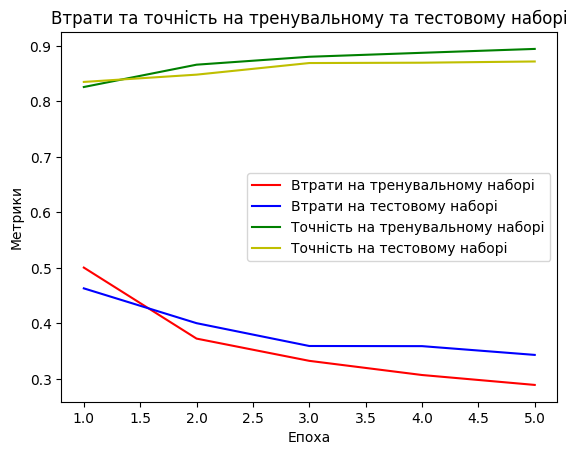

Testing value: 128
Epoch 1/5
469/469 [==============================] - 2s 4ms/step - loss: 0.5283 - accuracy: 0.8171 - val_loss: 0.4460 - val_accuracy: 0.8402
Epoch 2/5
469/469 [==============================] - 2s 4ms/step - loss: 0.3930 - accuracy: 0.8617 - val_loss: 0.4057 - val_accuracy: 0.8528
Epoch 3/5
469/469 [==============================] - 2s 5ms/step - loss: 0.3489 - accuracy: 0.8755 - val_loss: 0.3793 - val_accuracy: 0.8668
Epoch 4/5
469/469 [==============================] - 1s 3ms/step - loss: 0.3217 - accuracy: 0.8845 - val_loss: 0.3791 - val_accuracy: 0.8595
Epoch 5/5
313/313 [==============================] - 1s 2ms/step - loss: 0.3599 - accuracy: 0.8734
Точність на тестових даних: 0.8733999729156494
1875/1875 [==============================] - 5s 2ms/step - loss: 0.2895 - accuracy: 0.8969
Точність на тренувальних даних: 0.8969333171844482


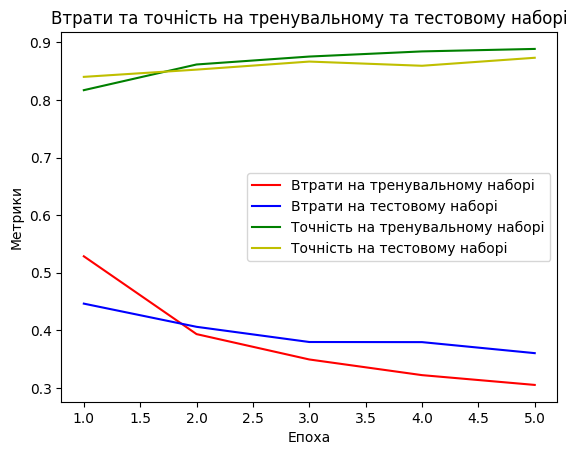

Testing value: 256
Epoch 1/5
235/235 [==============================] - 2s 4ms/step - loss: 0.5724 - accuracy: 0.8056 - val_loss: 0.4601 - val_accuracy: 0.8398
Epoch 2/5
235/235 [==============================] - 1s 3ms/step - loss: 0.4046 - accuracy: 0.8593 - val_loss: 0.4519 - val_accuracy: 0.8409
Epoch 3/5
235/235 [==============================] - 1s 3ms/step - loss: 0.3705 - accuracy: 0.8697 - val_loss: 0.3944 - val_accuracy: 0.8597
Epoch 4/5
235/235 [==============================] - 1s 3ms/step - loss: 0.3392 - accuracy: 0.8792 - val_loss: 0.3988 - val_accuracy: 0.8581
Epoch 5/5
313/313 [==============================] - 1s 2ms/step - loss: 0.3820 - accuracy: 0.8613
Точність на тестових даних: 0.861299991607666
1875/1875 [==============================] - 5s 2ms/step - loss: 0.3164 - accuracy: 0.8842
Точність на тренувальних даних: 0.8841833472251892


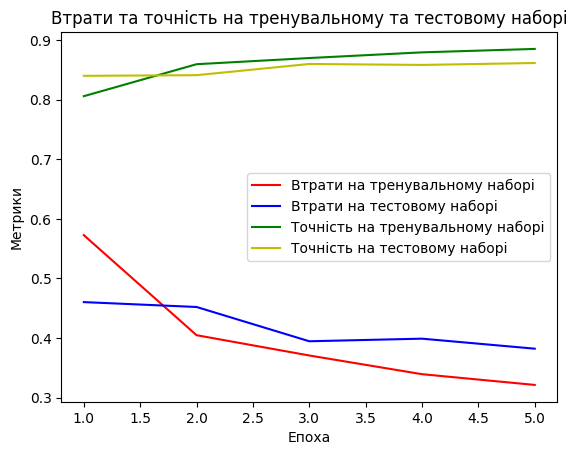

Optimal value for parameter batch_size: 128, test accuracy: 0.8733999729156494

Searching for optimal value for parameter: dropout_rate
Testing value: 0.0
Epoch 1/5
469/469 [==============================] - 2s 4ms/step - loss: 0.5204 - accuracy: 0.8200 - val_loss: 0.4586 - val_accuracy: 0.8320
Epoch 2/5
469/469 [==============================] - 1s 3ms/step - loss: 0.3904 - accuracy: 0.8607 - val_loss: 0.4338 - val_accuracy: 0.8414
Epoch 3/5
469/469 [==============================] - 2s 4ms/step - loss: 0.3458 - accuracy: 0.8765 - val_loss: 0.4002 - val_accuracy: 0.8565
Epoch 4/5
469/469 [==============================] - 2s 4ms/step - loss: 0.3233 - accuracy: 0.8824 - val_loss: 0.3848 - val_accuracy: 0.8634
Epoch 5/5
313/313 [==============================] - 1s 2ms/step - loss: 0.3607 - accuracy: 0.8700
Точність на тестових даних: 0.8700000047683716
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2887 - accuracy: 0.8946
Точність на тренувальних даних: 0.8945999741

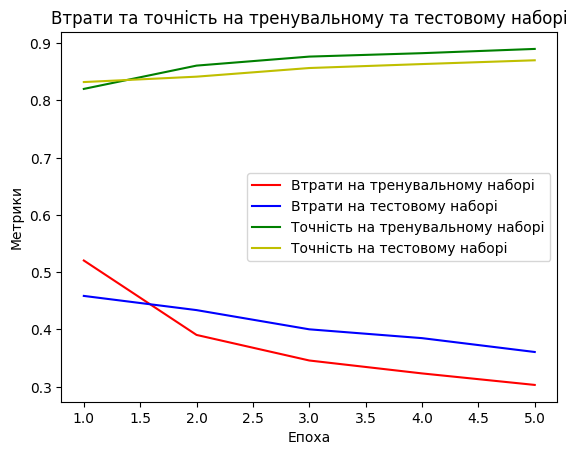

Testing value: 0.1
Epoch 1/5
469/469 [==============================] - 3s 5ms/step - loss: 0.5349 - accuracy: 0.8131 - val_loss: 0.4397 - val_accuracy: 0.8434
Epoch 2/5
469/469 [==============================] - 2s 4ms/step - loss: 0.3894 - accuracy: 0.8617 - val_loss: 0.3975 - val_accuracy: 0.8574
Epoch 3/5
469/469 [==============================] - 2s 3ms/step - loss: 0.3473 - accuracy: 0.8754 - val_loss: 0.3738 - val_accuracy: 0.8636
Epoch 4/5
469/469 [==============================] - 2s 4ms/step - loss: 0.3236 - accuracy: 0.8830 - val_loss: 0.3554 - val_accuracy: 0.8732
Epoch 5/5
313/313 [==============================] - 1s 2ms/step - loss: 0.3419 - accuracy: 0.8782
Точність на тестових даних: 0.8781999945640564
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2776 - accuracy: 0.9005
Точність на тренувальних даних: 0.9004833102226257


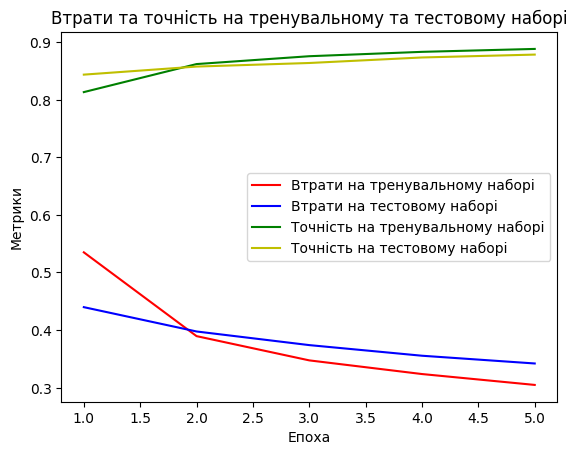

Testing value: 0.2
Epoch 1/5
469/469 [==============================] - 3s 4ms/step - loss: 0.5536 - accuracy: 0.8088 - val_loss: 0.4500 - val_accuracy: 0.8425
Epoch 2/5
469/469 [==============================] - 2s 4ms/step - loss: 0.3981 - accuracy: 0.8578 - val_loss: 0.3983 - val_accuracy: 0.8583
Epoch 3/5
469/469 [==============================] - 2s 3ms/step - loss: 0.3587 - accuracy: 0.8705 - val_loss: 0.3662 - val_accuracy: 0.8670
Epoch 4/5
469/469 [==============================] - 2s 4ms/step - loss: 0.3363 - accuracy: 0.8780 - val_loss: 0.3499 - val_accuracy: 0.8728
Epoch 5/5
313/313 [==============================] - 1s 2ms/step - loss: 0.3404 - accuracy: 0.8758
Точність на тестових даних: 0.8758000135421753
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2834 - accuracy: 0.8970
Точність на тренувальних даних: 0.8970166444778442


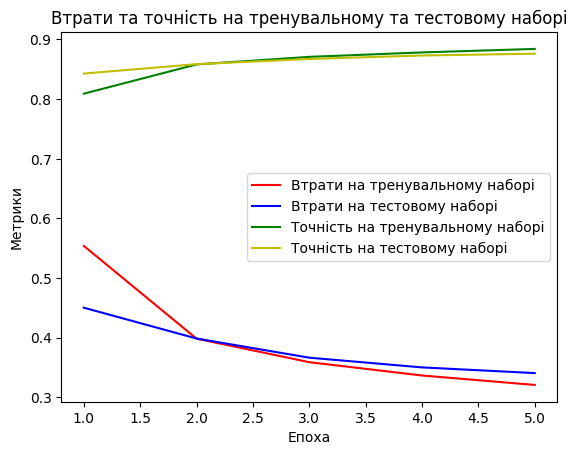

Testing value: 0.3
Epoch 1/5
469/469 [==============================] - 3s 5ms/step - loss: 0.5670 - accuracy: 0.8002 - val_loss: 0.4349 - val_accuracy: 0.8471
Epoch 2/5
469/469 [==============================] - 2s 4ms/step - loss: 0.4126 - accuracy: 0.8517 - val_loss: 0.3905 - val_accuracy: 0.8625
Epoch 3/5
469/469 [==============================] - 2s 3ms/step - loss: 0.3760 - accuracy: 0.8637 - val_loss: 0.3761 - val_accuracy: 0.8647
Epoch 4/5
469/469 [==============================] - 2s 3ms/step - loss: 0.3521 - accuracy: 0.8715 - val_loss: 0.3657 - val_accuracy: 0.8688
Epoch 5/5
313/313 [==============================] - 1s 2ms/step - loss: 0.3512 - accuracy: 0.8748
Точність на тестових даних: 0.8748000264167786
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2934 - accuracy: 0.8930
Точність на тренувальних даних: 0.8929833173751831


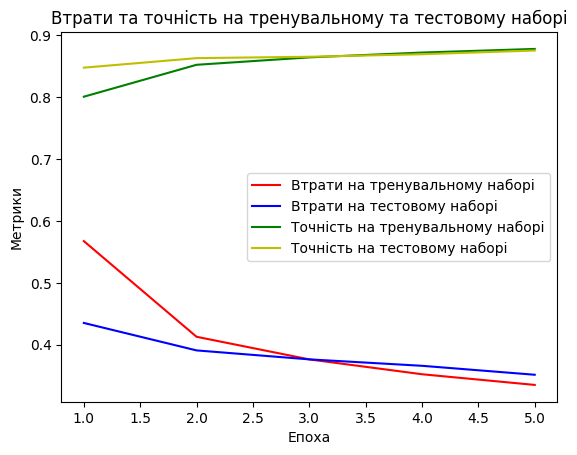

Optimal value for parameter dropout_rate: 0.1, test accuracy: 0.8781999945640564

Searching for optimal value for parameter: hidden_units
Testing value: 64
Epoch 1/5
469/469 [==============================] - 2s 4ms/step - loss: 0.6363 - accuracy: 0.7825 - val_loss: 0.4853 - val_accuracy: 0.8293
Epoch 2/5
469/469 [==============================] - 2s 4ms/step - loss: 0.4425 - accuracy: 0.8429 - val_loss: 0.4333 - val_accuracy: 0.8442
Epoch 3/5
469/469 [==============================] - 2s 3ms/step - loss: 0.3990 - accuracy: 0.8570 - val_loss: 0.4001 - val_accuracy: 0.8557
Epoch 4/5
469/469 [==============================] - 2s 3ms/step - loss: 0.3746 - accuracy: 0.8655 - val_loss: 0.3794 - val_accuracy: 0.8647
Epoch 5/5
313/313 [==============================] - 1s 3ms/step - loss: 0.3826 - accuracy: 0.8595
Точність на тестових даних: 0.859499990940094
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3263 - accuracy: 0.8802
Точність на тренувальних даних: 0.8801500201

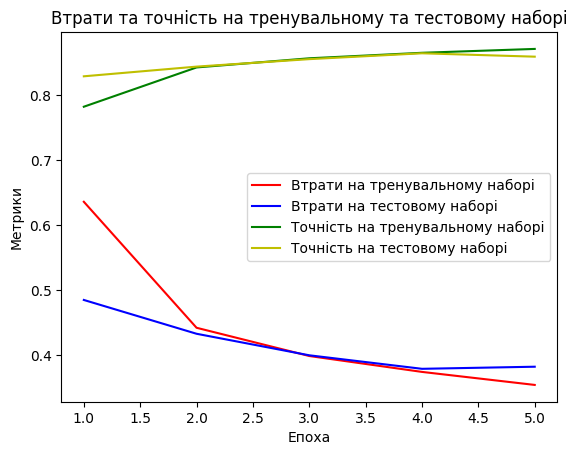

Testing value: 128
Epoch 1/5
469/469 [==============================] - 3s 4ms/step - loss: 0.5851 - accuracy: 0.7982 - val_loss: 0.4540 - val_accuracy: 0.8413
Epoch 2/5
469/469 [==============================] - 2s 4ms/step - loss: 0.4148 - accuracy: 0.8542 - val_loss: 0.4182 - val_accuracy: 0.8496
Epoch 3/5
469/469 [==============================] - 2s 4ms/step - loss: 0.3696 - accuracy: 0.8683 - val_loss: 0.3857 - val_accuracy: 0.8614
Epoch 4/5
469/469 [==============================] - 2s 3ms/step - loss: 0.3461 - accuracy: 0.8752 - val_loss: 0.3835 - val_accuracy: 0.8605
Epoch 5/5
313/313 [==============================] - 1s 2ms/step - loss: 0.3588 - accuracy: 0.8698
Точність на тестових даних: 0.8697999715805054
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2996 - accuracy: 0.8914
Точність на тренувальних даних: 0.8913999795913696


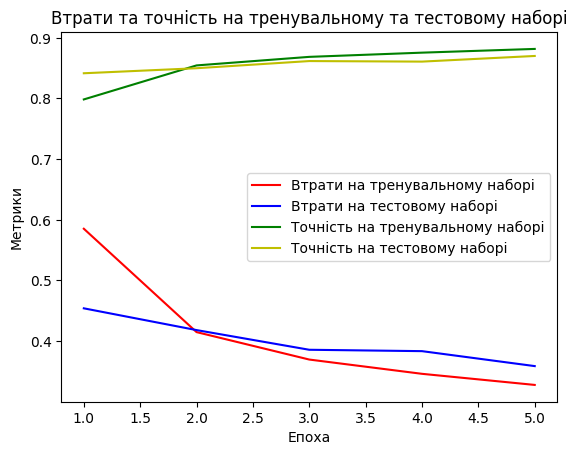

Testing value: 256
Epoch 1/5
469/469 [==============================] - 3s 4ms/step - loss: 0.5351 - accuracy: 0.8141 - val_loss: 0.4409 - val_accuracy: 0.8425
Epoch 2/5
469/469 [==============================] - 2s 3ms/step - loss: 0.3924 - accuracy: 0.8607 - val_loss: 0.4114 - val_accuracy: 0.8544
Epoch 3/5
469/469 [==============================] - 2s 4ms/step - loss: 0.3524 - accuracy: 0.8720 - val_loss: 0.3695 - val_accuracy: 0.8675
Epoch 4/5
469/469 [==============================] - 2s 4ms/step - loss: 0.3265 - accuracy: 0.8798 - val_loss: 0.3525 - val_accuracy: 0.8735
Epoch 5/5
313/313 [==============================] - 1s 2ms/step - loss: 0.3531 - accuracy: 0.8750
Точність на тестових даних: 0.875
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2833 - accuracy: 0.8957
Точність на тренувальних даних: 0.8956833481788635


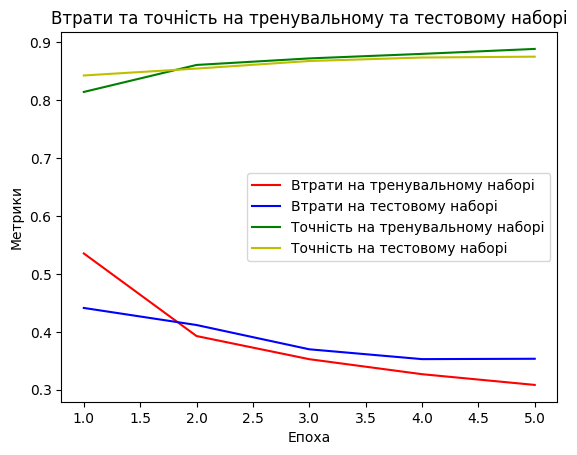

Optimal value for parameter hidden_units: 256, test accuracy: 0.8781999945640564

Searching for optimal value for parameter: loss_function
Testing value: sparse_categorical_crossentropy
Epoch 1/5
469/469 [==============================] - 3s 5ms/step - loss: 0.5345 - accuracy: 0.8137 - val_loss: 0.4514 - val_accuracy: 0.8369
Epoch 2/5
469/469 [==============================] - 2s 4ms/step - loss: 0.3904 - accuracy: 0.8600 - val_loss: 0.3903 - val_accuracy: 0.8576
Epoch 3/5
469/469 [==============================] - 2s 4ms/step - loss: 0.3502 - accuracy: 0.8738 - val_loss: 0.3750 - val_accuracy: 0.8652
Epoch 4/5
469/469 [==============================] - 2s 3ms/step - loss: 0.3257 - accuracy: 0.8822 - val_loss: 0.3588 - val_accuracy: 0.8733
Epoch 5/5
313/313 [==============================] - 1s 2ms/step - loss: 0.3679 - accuracy: 0.8642
Точність на тестових даних: 0.8641999959945679
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3019 - accuracy: 0.8885
Точність на т

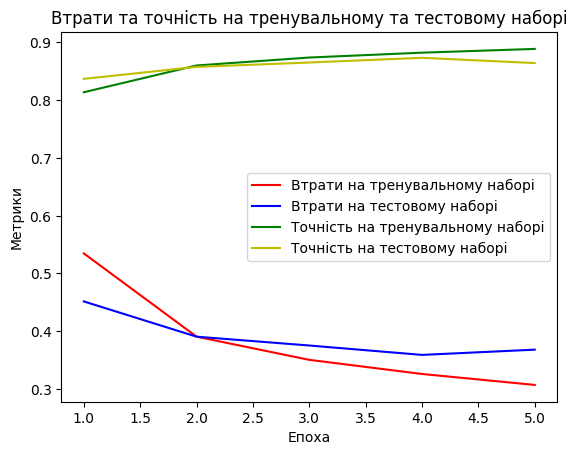

Optimal value for parameter loss_function: sparse_categorical_crossentropy, test accuracy: 0.8781999945640564

Searching for optimal value for parameter: optimizer
Testing value: adam
Epoch 1/5
469/469 [==============================] - 2s 4ms/step - loss: 0.5350 - accuracy: 0.8154 - val_loss: 0.4346 - val_accuracy: 0.8468
Epoch 2/5
469/469 [==============================] - 2s 3ms/step - loss: 0.3923 - accuracy: 0.8597 - val_loss: 0.4049 - val_accuracy: 0.8527
Epoch 3/5
469/469 [==============================] - 2s 4ms/step - loss: 0.3504 - accuracy: 0.8749 - val_loss: 0.3973 - val_accuracy: 0.8589
Epoch 4/5
469/469 [==============================] - 2s 3ms/step - loss: 0.3274 - accuracy: 0.8811 - val_loss: 0.3662 - val_accuracy: 0.8611
Epoch 5/5
313/313 [==============================] - 1s 3ms/step - loss: 0.3470 - accuracy: 0.8734
Точність на тестових даних: 0.8733999729156494
1875/1875 [==============================] - 5s 2ms/step - loss: 0.2842 - accuracy: 0.8957
Точність на тре

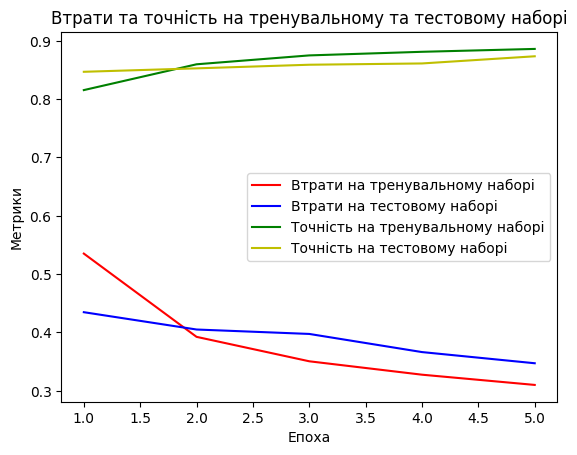

Testing value: rmsprop
Epoch 1/5
469/469 [==============================] - 3s 4ms/step - loss: 0.5709 - accuracy: 0.7993 - val_loss: 0.4790 - val_accuracy: 0.8304
Epoch 2/5
469/469 [==============================] - 2s 4ms/step - loss: 0.3996 - accuracy: 0.8557 - val_loss: 0.4010 - val_accuracy: 0.8582
Epoch 3/5
469/469 [==============================] - 2s 4ms/step - loss: 0.3562 - accuracy: 0.8698 - val_loss: 0.3730 - val_accuracy: 0.8637
Epoch 4/5
469/469 [==============================] - 2s 5ms/step - loss: 0.3305 - accuracy: 0.8789 - val_loss: 0.3727 - val_accuracy: 0.8656
Epoch 5/5
313/313 [==============================] - 1s 2ms/step - loss: 0.3523 - accuracy: 0.8749
Точність на тестових даних: 0.8748999834060669
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2851 - accuracy: 0.8967
Точність на тренувальних даних: 0.8967499732971191


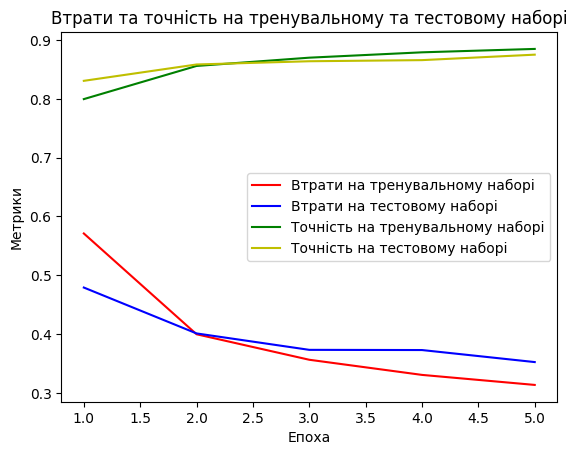

Testing value: sgd
Epoch 1/5
469/469 [==============================] - 3s 5ms/step - loss: 1.0918 - accuracy: 0.6615 - val_loss: 0.7714 - val_accuracy: 0.7403
Epoch 2/5
469/469 [==============================] - 2s 3ms/step - loss: 0.7089 - accuracy: 0.7642 - val_loss: 0.6543 - val_accuracy: 0.7786
Epoch 3/5
469/469 [==============================] - 2s 4ms/step - loss: 0.6278 - accuracy: 0.7910 - val_loss: 0.5998 - val_accuracy: 0.7972
Epoch 4/5
469/469 [==============================] - 2s 3ms/step - loss: 0.5814 - accuracy: 0.8064 - val_loss: 0.5682 - val_accuracy: 0.8059
Epoch 5/5
313/313 [==============================] - 1s 2ms/step - loss: 0.5459 - accuracy: 0.8100
Точність на тестових даних: 0.8100000023841858
1875/1875 [==============================] - 5s 3ms/step - loss: 0.5210 - accuracy: 0.8260
Точність на тренувальних даних: 0.8260499835014343


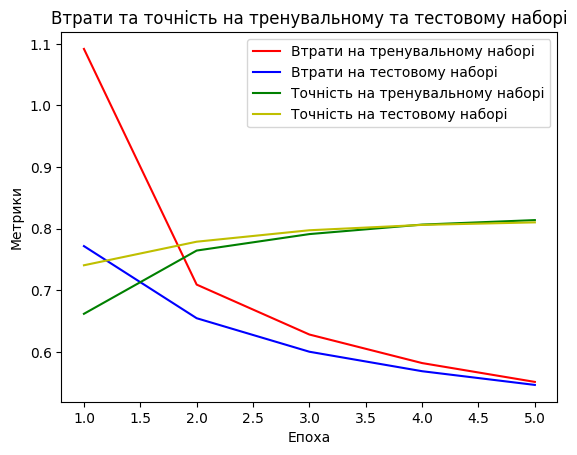

Optimal value for parameter optimizer: adam, test accuracy: 0.8781999945640564

Searching for optimal value for parameter: activation
Testing value: relu
Epoch 1/5
469/469 [==============================] - 3s 4ms/step - loss: 0.5314 - accuracy: 0.8162 - val_loss: 0.4329 - val_accuracy: 0.8474
Epoch 2/5
469/469 [==============================] - 2s 4ms/step - loss: 0.3892 - accuracy: 0.8615 - val_loss: 0.3885 - val_accuracy: 0.8604
Epoch 3/5
469/469 [==============================] - 2s 4ms/step - loss: 0.3499 - accuracy: 0.8724 - val_loss: 0.3786 - val_accuracy: 0.8616
Epoch 4/5
469/469 [==============================] - 2s 4ms/step - loss: 0.3238 - accuracy: 0.8812 - val_loss: 0.3508 - val_accuracy: 0.8745
Epoch 5/5
313/313 [==============================] - 1s 2ms/step - loss: 0.3471 - accuracy: 0.8705
Точність на тестових даних: 0.8705000281333923
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2826 - accuracy: 0.8954
Точність на тренувальних даних: 0.89544999599

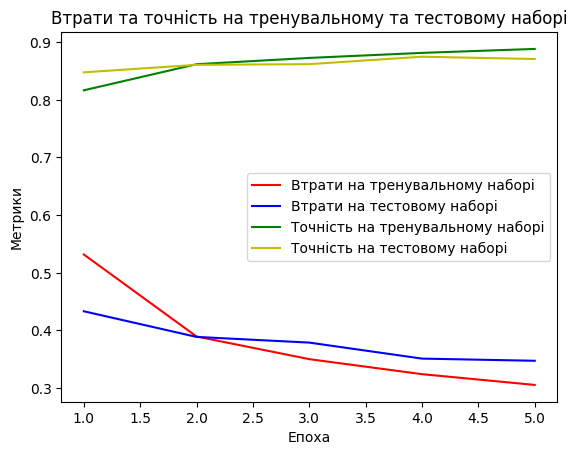

Testing value: sigmoid
Epoch 1/5
469/469 [==============================] - 3s 5ms/step - loss: 0.6253 - accuracy: 0.7850 - val_loss: 0.4848 - val_accuracy: 0.8230
Epoch 2/5
469/469 [==============================] - 4s 8ms/step - loss: 0.4400 - accuracy: 0.8418 - val_loss: 0.4419 - val_accuracy: 0.8397
Epoch 3/5
469/469 [==============================] - 2s 4ms/step - loss: 0.4009 - accuracy: 0.8565 - val_loss: 0.4126 - val_accuracy: 0.8495
Epoch 4/5
469/469 [==============================] - 2s 4ms/step - loss: 0.3749 - accuracy: 0.8660 - val_loss: 0.3943 - val_accuracy: 0.8577
Epoch 5/5
313/313 [==============================] - 1s 2ms/step - loss: 0.3872 - accuracy: 0.8591
Точність на тестових даних: 0.8590999841690063
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3404 - accuracy: 0.8766
Точність на тренувальних даних: 0.8766166567802429


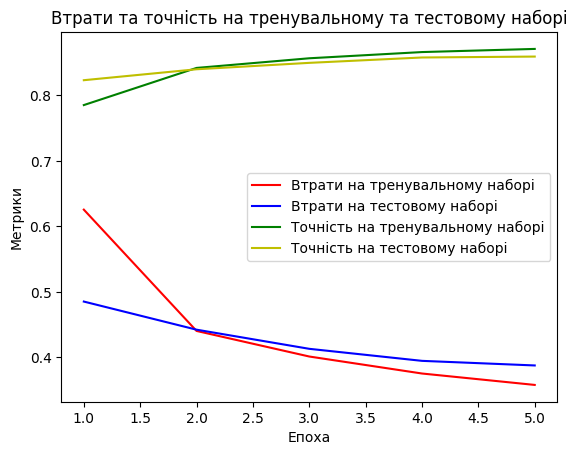

Testing value: tanh
Epoch 1/5
469/469 [==============================] - 3s 4ms/step - loss: 0.5211 - accuracy: 0.8152 - val_loss: 0.4356 - val_accuracy: 0.8495
Epoch 2/5
469/469 [==============================] - 2s 5ms/step - loss: 0.4026 - accuracy: 0.8553 - val_loss: 0.4329 - val_accuracy: 0.8464
Epoch 3/5
469/469 [==============================] - 2s 3ms/step - loss: 0.3712 - accuracy: 0.8650 - val_loss: 0.3835 - val_accuracy: 0.8627
Epoch 4/5
469/469 [==============================] - 2s 3ms/step - loss: 0.3480 - accuracy: 0.8735 - val_loss: 0.3796 - val_accuracy: 0.8655
Epoch 5/5
313/313 [==============================] - 1s 2ms/step - loss: 0.3802 - accuracy: 0.8622
Точність на тестових даних: 0.8622000217437744
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3174 - accuracy: 0.8825
Точність на тренувальних даних: 0.8825166821479797


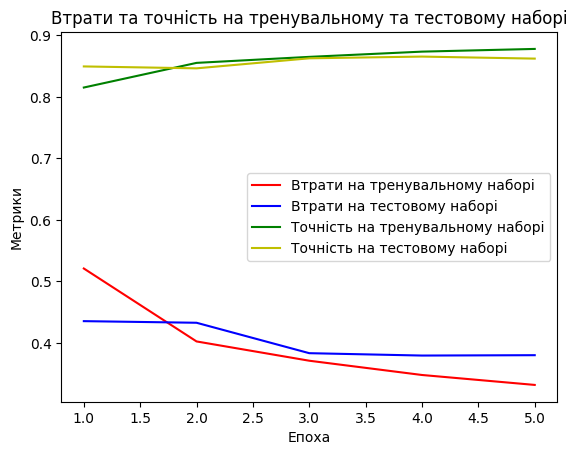

Optimal value for parameter activation: relu, test accuracy: 0.8781999945640564

Searching for optimal value for parameter: metrics
Testing value: accuracy
Epoch 1/5
469/469 [==============================] - 3s 4ms/step - loss: 0.5349 - accuracy: 0.8129 - val_loss: 0.4560 - val_accuracy: 0.8384
Epoch 2/5
469/469 [==============================] - 2s 4ms/step - loss: 0.3926 - accuracy: 0.8608 - val_loss: 0.4032 - val_accuracy: 0.8529
Epoch 3/5
469/469 [==============================] - 2s 4ms/step - loss: 0.3497 - accuracy: 0.8736 - val_loss: 0.3673 - val_accuracy: 0.8717
Epoch 4/5
469/469 [==============================] - 2s 3ms/step - loss: 0.3267 - accuracy: 0.8805 - val_loss: 0.3497 - val_accuracy: 0.8743
Epoch 5/5
313/313 [==============================] - 1s 2ms/step - loss: 0.3535 - accuracy: 0.8741
Точність на тестових даних: 0.8741000294685364
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2828 - accuracy: 0.8959
Точність на тренувальних даних: 0.895933330

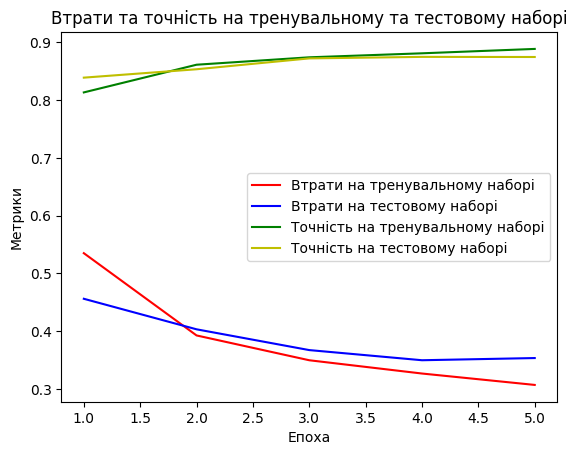

Optimal value for parameter metrics: ['accuracy'], test accuracy: 0.8781999945640564

Searching for optimal value for parameter: epochs
Testing value: 5
Epoch 1/5
469/469 [==============================] - 3s 4ms/step - loss: 0.5429 - accuracy: 0.8113 - val_loss: 0.4494 - val_accuracy: 0.8421
Epoch 2/5
469/469 [==============================] - 2s 4ms/step - loss: 0.3924 - accuracy: 0.8602 - val_loss: 0.4057 - val_accuracy: 0.8538
Epoch 3/5
469/469 [==============================] - 2s 3ms/step - loss: 0.3527 - accuracy: 0.8734 - val_loss: 0.3684 - val_accuracy: 0.8652
Epoch 4/5
469/469 [==============================] - 2s 3ms/step - loss: 0.3241 - accuracy: 0.8812 - val_loss: 0.3499 - val_accuracy: 0.8721
Epoch 5/5
313/313 [==============================] - 1s 2ms/step - loss: 0.3406 - accuracy: 0.8784
Точність на тестових даних: 0.8784000277519226
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2720 - accuracy: 0.9012
Точність на тренувальних даних: 0.901233315467

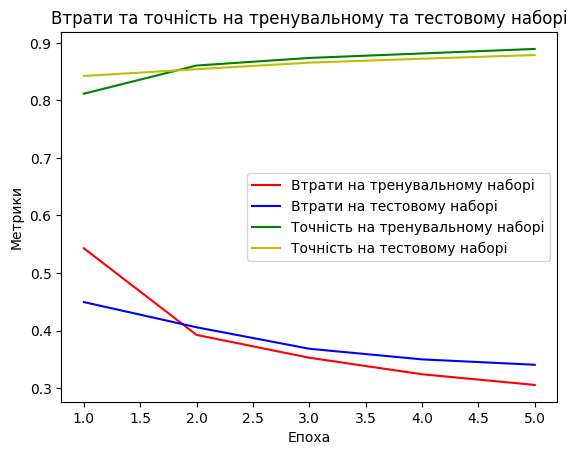

Testing value: 10
Epoch 1/10
469/469 [==============================] - 2s 4ms/step - loss: 0.5414 - accuracy: 0.8115 - val_loss: 0.4576 - val_accuracy: 0.8334
Epoch 2/10
469/469 [==============================] - 2s 3ms/step - loss: 0.3922 - accuracy: 0.8603 - val_loss: 0.3917 - val_accuracy: 0.8592
Epoch 3/10
469/469 [==============================] - 2s 3ms/step - loss: 0.3504 - accuracy: 0.8744 - val_loss: 0.3763 - val_accuracy: 0.8646
Epoch 4/10
469/469 [==============================] - 2s 3ms/step - loss: 0.3268 - accuracy: 0.8801 - val_loss: 0.3590 - val_accuracy: 0.8713
Epoch 5/10
469/469 [==============================] - 2s 3ms/step - loss: 0.3103 - accuracy: 0.8877 - val_loss: 0.3472 - val_accuracy: 0.8752
Epoch 6/10
469/469 [==============================] - 2s 5ms/step - loss: 0.2945 - accuracy: 0.8919 - val_loss: 0.3350 - val_accuracy: 0.8794
Epoch 7/10
469/469 [==============================] - 2s 4ms/step - loss: 0.2816 - accuracy: 0.8967 - val_loss: 0.3261 - val_accur

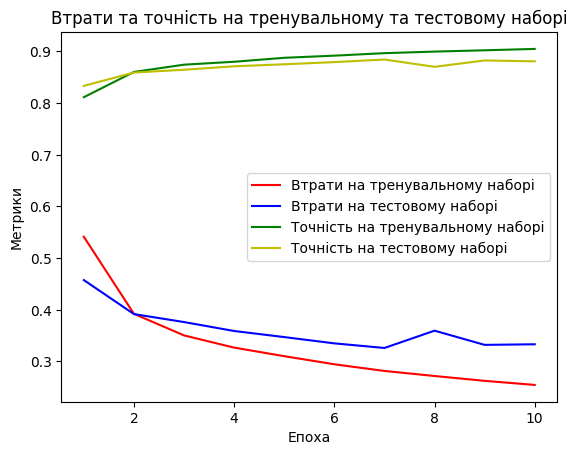

Testing value: 20
Epoch 1/20
469/469 [==============================] - 3s 4ms/step - loss: 0.5325 - accuracy: 0.8142 - val_loss: 0.4282 - val_accuracy: 0.8503
Epoch 2/20
469/469 [==============================] - 2s 4ms/step - loss: 0.3899 - accuracy: 0.8612 - val_loss: 0.3849 - val_accuracy: 0.8631
Epoch 3/20
469/469 [==============================] - 2s 4ms/step - loss: 0.3516 - accuracy: 0.8724 - val_loss: 0.3706 - val_accuracy: 0.8669
Epoch 4/20
469/469 [==============================] - 2s 4ms/step - loss: 0.3281 - accuracy: 0.8807 - val_loss: 0.3568 - val_accuracy: 0.8716
Epoch 5/20
469/469 [==============================] - 2s 4ms/step - loss: 0.3074 - accuracy: 0.8876 - val_loss: 0.3506 - val_accuracy: 0.8733
Epoch 6/20
469/469 [==============================] - 2s 5ms/step - loss: 0.2936 - accuracy: 0.8922 - val_loss: 0.3411 - val_accuracy: 0.8747
Epoch 7/20
469/469 [==============================] - 2s 4ms/step - loss: 0.2832 - accuracy: 0.8953 - val_loss: 0.3539 - val_accur

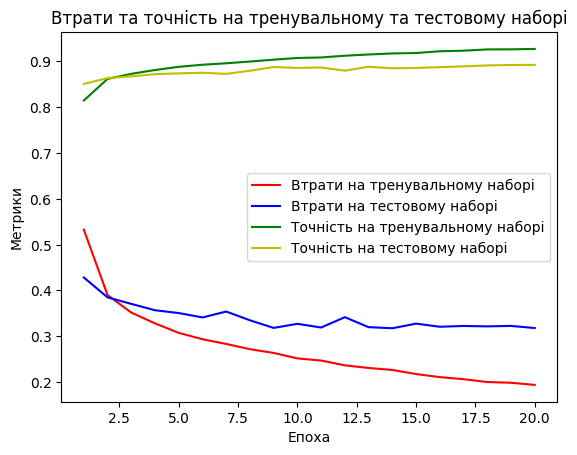

Testing value: 50
Epoch 1/50
469/469 [==============================] - 3s 4ms/step - loss: 0.5386 - accuracy: 0.8120 - val_loss: 0.4310 - val_accuracy: 0.8483
Epoch 2/50
469/469 [==============================] - 2s 5ms/step - loss: 0.3932 - accuracy: 0.8587 - val_loss: 0.3849 - val_accuracy: 0.8620
Epoch 3/50
469/469 [==============================] - 2s 4ms/step - loss: 0.3530 - accuracy: 0.8732 - val_loss: 0.3661 - val_accuracy: 0.8707
Epoch 4/50
469/469 [==============================] - 2s 4ms/step - loss: 0.3274 - accuracy: 0.8806 - val_loss: 0.3499 - val_accuracy: 0.8770
Epoch 5/50
469/469 [==============================] - 2s 4ms/step - loss: 0.3104 - accuracy: 0.8853 - val_loss: 0.3449 - val_accuracy: 0.8762
Epoch 6/50
469/469 [==============================] - 2s 4ms/step - loss: 0.2929 - accuracy: 0.8915 - val_loss: 0.3583 - val_accuracy: 0.8733
Epoch 7/50
469/469 [==============================] - 2s 4ms/step - loss: 0.2843 - accuracy: 0.8958 - val_loss: 0.3411 - val_accur

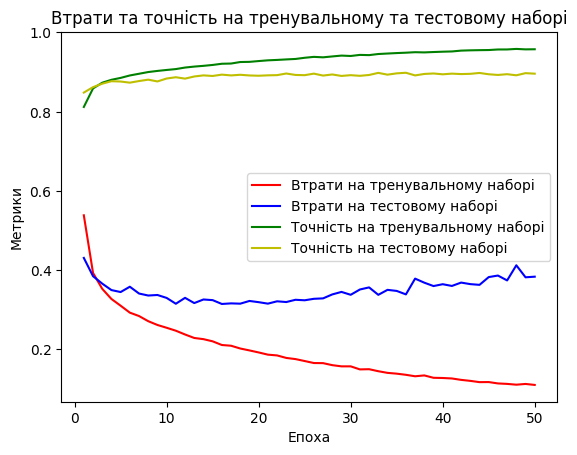

Optimal value for parameter epochs: 50, test accuracy: 0.8960000276565552

Optimal parameters:
{'epochs': 50, 'batch_size': 128, 'dropout_rate': 0.1, 'loss_function': 'sparse_categorical_crossentropy', 'optimizer': 'adam', 'hidden_units': 256, 'activation': 'relu', 'metrics': ['accuracy']}
Test accuracy: 0.8960000276565552


In [35]:
find_optimal_1 = find_optimal_parameters(train_images, train_labels, test_images, test_labels, parameters, optimal_parameters, study_sequence, train_model)



  **Для моделі 1:**
```
model = models.Sequential([
        layers.Flatten(input_shape=[28, 28, 1]),
        layers.Dense(hidden_units, activation=activation),
        layers.Dropout(dropout_rate),
        layers.Dense(10, activation='softmax')
    ])

model.compile(optimizer=optimizer,
                  loss=loss_function,
                  metrics=metrics)
```
**оптимальні параметри:**
```
{'epochs': 50,
 'batch_size': 128,
 'dropout_rate': 0.1,
 'loss_function': 'sparse_categorical_crossentropy',
 'optimizer': 'adam',
 'hidden_units': 256,
 'activation': 'relu',
 'metrics': ['accuracy']}
 ```
**Проте точність моделі недостатня**



In [36]:
optimal_parameters

{'epochs': 50,
 'batch_size': 128,
 'dropout_rate': 0.1,
 'loss_function': 'sparse_categorical_crossentropy',
 'optimizer': 'adam',
 'hidden_units': 256,
 'activation': 'relu',
 'metrics': ['accuracy']}

**МОДЕЛЬ 2**

---


**Змінимо будову моделі 1 і повторимо перевірку оптимальних параметрів**

Перелік параметрів скоротимо до:
1. 'dropout_rate',
2. 'hidden_units',
3. 'epochs'

Додаткові Dense-шари мають змінне число нейронів, що менше у 2 і у 4 рази порівняно з вихідним dense-шаром

In [7]:
def train_model2(train_images, train_labels, test_images, test_labels, epochs=15, batch_size=32, dropout_rate=0.2,
                loss_function='sparse_categorical_crossentropy', optimizer='adam', hidden_units=128,
                activation='relu', metrics=['accuracy']):

    model = models.Sequential([
    layers.Flatten(input_shape=(28, 28, 1)),
    layers.Dense(hidden_units, activation='relu'),
    layers.Dropout(dropout_rate),
    layers.Dense(hidden_units/2, activation='relu'),  # Додатковий Dense шар
    layers.Dropout(dropout_rate),
    layers.Dense(hidden_units/4, activation='relu'),   # Додатковий Dense шар
    layers.Dropout(dropout_rate),
    layers.Dense(10, activation='softmax')
    ])


    model.compile(optimizer=optimizer,
              loss=loss_function,
              metrics=metrics)

    history = model.fit(train_images, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(test_images, test_labels))

    test_loss, test_acc = model.evaluate(test_images, test_labels)
    print('Точність на тестових даних:', test_acc)

    train_loss, train_acc = model.evaluate(train_images, train_labels)
    print('Точність на тренувальних даних:', train_acc)

    return model, history, test_acc, train_acc

**Змінювати будемо параметри:**

1. 'dropout_rate'
2. 'hidden_units'

Searching for optimal value for parameter: dropout_rate
Testing value: 0.0
Epoch 1/5
469/469 [==============================] - 3s 4ms/step - loss: 0.6285 - accuracy: 0.7853 - val_loss: 0.4887 - val_accuracy: 0.8233
Epoch 2/5
469/469 [==============================] - 2s 4ms/step - loss: 0.4291 - accuracy: 0.8492 - val_loss: 0.4581 - val_accuracy: 0.8392
Epoch 3/5
469/469 [==============================] - 2s 4ms/step - loss: 0.3933 - accuracy: 0.8609 - val_loss: 0.4118 - val_accuracy: 0.8558
Epoch 4/5
469/469 [==============================] - 2s 5ms/step - loss: 0.3686 - accuracy: 0.8695 - val_loss: 0.4062 - val_accuracy: 0.8536
Epoch 5/5
313/313 [==============================] - 1s 2ms/step - loss: 0.4109 - accuracy: 0.8519
Точність на тестових даних: 0.8518999814987183
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3523 - accuracy: 0.8723
Точність на тренувальних даних: 0.8722666501998901


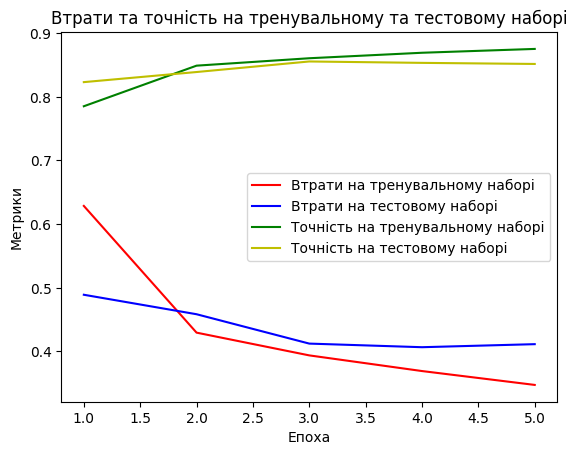

Testing value: 0.1
Epoch 1/5
469/469 [==============================] - 4s 5ms/step - loss: 0.9001 - accuracy: 0.6710 - val_loss: 0.5424 - val_accuracy: 0.7926
Epoch 2/5
469/469 [==============================] - 2s 4ms/step - loss: 0.5618 - accuracy: 0.8006 - val_loss: 0.4597 - val_accuracy: 0.8385
Epoch 3/5
469/469 [==============================] - 2s 4ms/step - loss: 0.4752 - accuracy: 0.8325 - val_loss: 0.4236 - val_accuracy: 0.8468
Epoch 4/5
469/469 [==============================] - 2s 4ms/step - loss: 0.4365 - accuracy: 0.8463 - val_loss: 0.4110 - val_accuracy: 0.8536
Epoch 5/5
313/313 [==============================] - 1s 2ms/step - loss: 0.4027 - accuracy: 0.8555
Точність на тестових даних: 0.8554999828338623
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3400 - accuracy: 0.8764
Точність на тренувальних даних: 0.8764333128929138


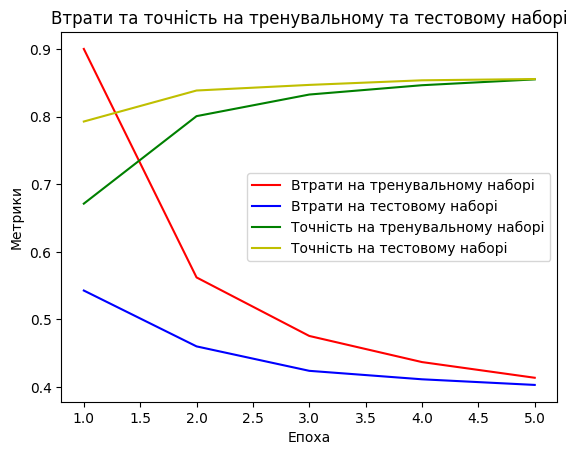

Testing value: 0.2
Epoch 1/5
469/469 [==============================] - 3s 4ms/step - loss: 1.0295 - accuracy: 0.6238 - val_loss: 0.5505 - val_accuracy: 0.8077
Epoch 2/5
469/469 [==============================] - 2s 4ms/step - loss: 0.6452 - accuracy: 0.7725 - val_loss: 0.4728 - val_accuracy: 0.8350
Epoch 3/5
469/469 [==============================] - 2s 4ms/step - loss: 0.5655 - accuracy: 0.8058 - val_loss: 0.4443 - val_accuracy: 0.8387
Epoch 4/5
469/469 [==============================] - 2s 5ms/step - loss: 0.5276 - accuracy: 0.8219 - val_loss: 0.4299 - val_accuracy: 0.8491
Epoch 5/5
313/313 [==============================] - 1s 2ms/step - loss: 0.4045 - accuracy: 0.8578
Точність на тестових даних: 0.8578000068664551
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3591 - accuracy: 0.8728
Точність на тренувальних даних: 0.8728166818618774


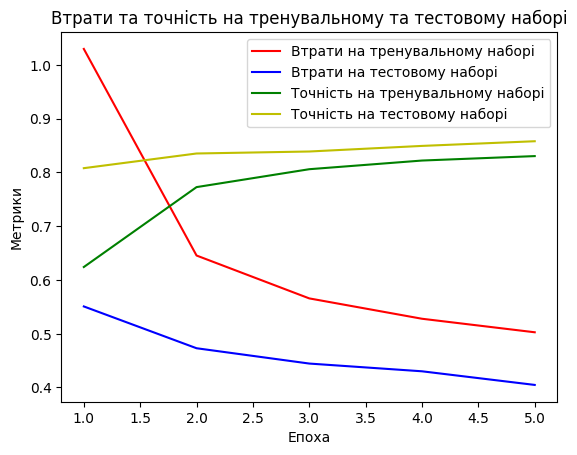

Testing value: 0.3
Epoch 1/5
469/469 [==============================] - 4s 5ms/step - loss: 1.2875 - accuracy: 0.5431 - val_loss: 0.6142 - val_accuracy: 0.7978
Epoch 2/5
469/469 [==============================] - 2s 4ms/step - loss: 0.7924 - accuracy: 0.7142 - val_loss: 0.5216 - val_accuracy: 0.8226
Epoch 3/5
469/469 [==============================] - 2s 4ms/step - loss: 0.6937 - accuracy: 0.7544 - val_loss: 0.4820 - val_accuracy: 0.8372
Epoch 4/5
469/469 [==============================] - 2s 4ms/step - loss: 0.6499 - accuracy: 0.7761 - val_loss: 0.4601 - val_accuracy: 0.8416
Epoch 5/5
313/313 [==============================] - 1s 2ms/step - loss: 0.4659 - accuracy: 0.8410
Точність на тестових даних: 0.8410000205039978
1875/1875 [==============================] - 5s 3ms/step - loss: 0.4158 - accuracy: 0.8576
Точність на тренувальних даних: 0.8575999736785889


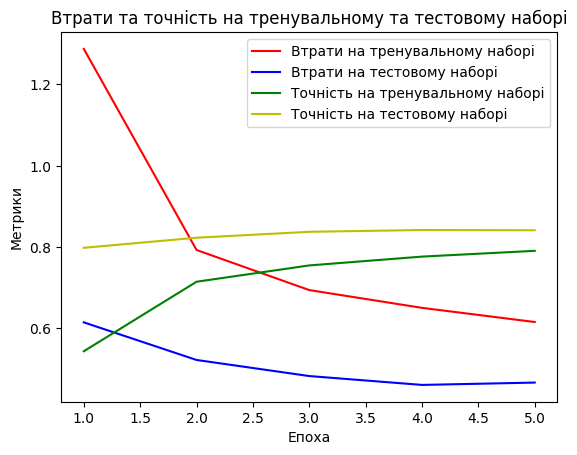

Optimal value for parameter dropout_rate: 0.2, test accuracy: 0.8578000068664551

Searching for optimal value for parameter: hidden_units
Testing value: 64
Epoch 1/5
469/469 [==============================] - 3s 5ms/step - loss: 1.0166 - accuracy: 0.6459 - val_loss: 0.5283 - val_accuracy: 0.8144
Epoch 2/5
469/469 [==============================] - 2s 4ms/step - loss: 0.6237 - accuracy: 0.7848 - val_loss: 0.4581 - val_accuracy: 0.8393
Epoch 3/5
469/469 [==============================] - 2s 4ms/step - loss: 0.5532 - accuracy: 0.8108 - val_loss: 0.4423 - val_accuracy: 0.8429
Epoch 4/5
469/469 [==============================] - 2s 5ms/step - loss: 0.5175 - accuracy: 0.8235 - val_loss: 0.4207 - val_accuracy: 0.8544
Epoch 5/5
313/313 [==============================] - 1s 2ms/step - loss: 0.4136 - accuracy: 0.8579
Точність на тестових даних: 0.8579000234603882
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3575 - accuracy: 0.8706
Точність на тренувальних даних: 0.870633304

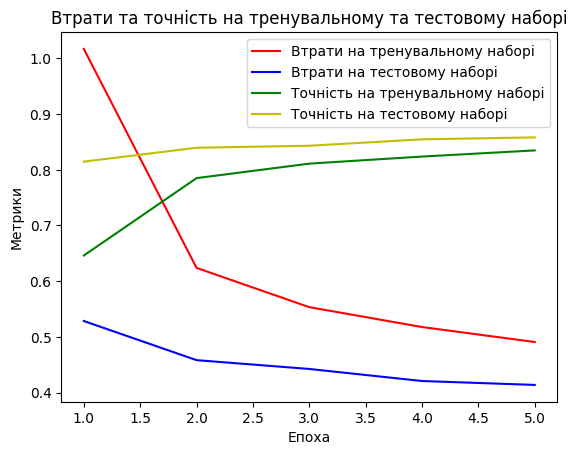

Testing value: 128
Epoch 1/5
469/469 [==============================] - 4s 6ms/step - loss: 0.7954 - accuracy: 0.7312 - val_loss: 0.4816 - val_accuracy: 0.8261
Epoch 2/5
469/469 [==============================] - 2s 4ms/step - loss: 0.4927 - accuracy: 0.8297 - val_loss: 0.4320 - val_accuracy: 0.8443
Epoch 3/5
469/469 [==============================] - 2s 4ms/step - loss: 0.4436 - accuracy: 0.8455 - val_loss: 0.3936 - val_accuracy: 0.8589
Epoch 4/5
469/469 [==============================] - 2s 4ms/step - loss: 0.4098 - accuracy: 0.8564 - val_loss: 0.3949 - val_accuracy: 0.8565
Epoch 5/5
313/313 [==============================] - 1s 2ms/step - loss: 0.3776 - accuracy: 0.8666
Точність на тестових даних: 0.866599977016449
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3147 - accuracy: 0.8849
Точність на тренувальних даних: 0.8849166631698608


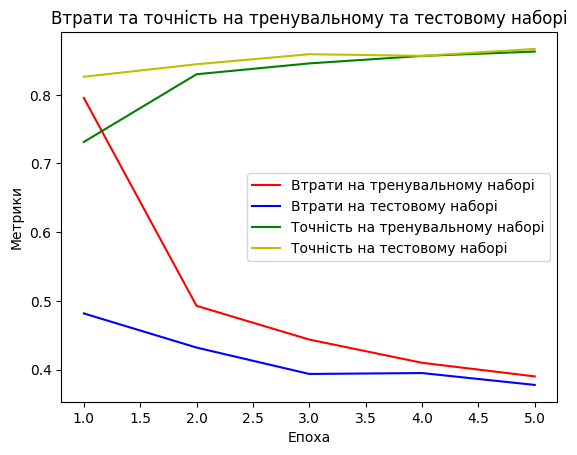

Testing value: 256
Epoch 1/5
469/469 [==============================] - 4s 5ms/step - loss: 0.6495 - accuracy: 0.7674 - val_loss: 0.4350 - val_accuracy: 0.8468
Epoch 2/5
469/469 [==============================] - 2s 4ms/step - loss: 0.4361 - accuracy: 0.8439 - val_loss: 0.3913 - val_accuracy: 0.8556
Epoch 3/5
469/469 [==============================] - 2s 5ms/step - loss: 0.3949 - accuracy: 0.8571 - val_loss: 0.3780 - val_accuracy: 0.8626
Epoch 4/5
469/469 [==============================] - 2s 5ms/step - loss: 0.3685 - accuracy: 0.8672 - val_loss: 0.3808 - val_accuracy: 0.8637
Epoch 5/5
313/313 [==============================] - 1s 2ms/step - loss: 0.3611 - accuracy: 0.8731
Точність на тестових даних: 0.8730999827384949
1875/1875 [==============================] - 5s 2ms/step - loss: 0.2947 - accuracy: 0.8921
Точність на тренувальних даних: 0.8921166658401489


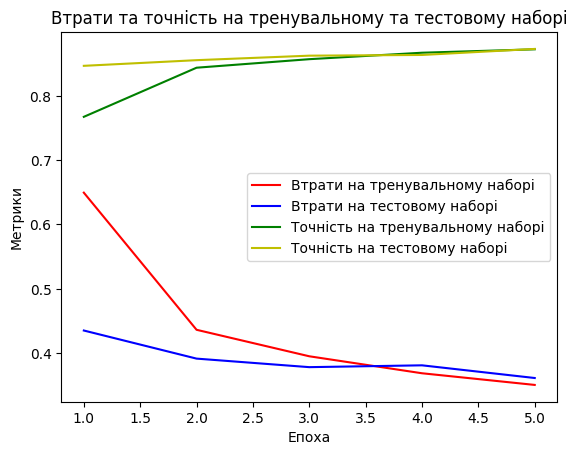

Optimal value for parameter hidden_units: 256, test accuracy: 0.8730999827384949

Searching for optimal value for parameter: epochs
Testing value: 10
Epoch 1/10
469/469 [==============================] - 4s 4ms/step - loss: 0.6567 - accuracy: 0.7656 - val_loss: 0.4383 - val_accuracy: 0.8402
Epoch 2/10
469/469 [==============================] - 2s 4ms/step - loss: 0.4362 - accuracy: 0.8441 - val_loss: 0.3985 - val_accuracy: 0.8526
Epoch 3/10
469/469 [==============================] - 2s 4ms/step - loss: 0.3927 - accuracy: 0.8594 - val_loss: 0.3757 - val_accuracy: 0.8633
Epoch 4/10
469/469 [==============================] - 2s 4ms/step - loss: 0.3704 - accuracy: 0.8673 - val_loss: 0.3557 - val_accuracy: 0.8741
Epoch 5/10
469/469 [==============================] - 2s 4ms/step - loss: 0.3495 - accuracy: 0.8727 - val_loss: 0.3608 - val_accuracy: 0.8742
Epoch 6/10
469/469 [==============================] - 3s 5ms/step - loss: 0.3371 - accuracy: 0.8759 - val_loss: 0.3466 - val_accuracy: 0.877

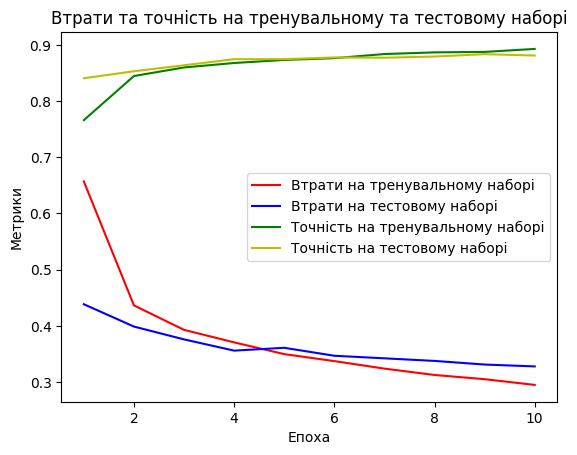

Testing value: 20
Epoch 1/20
469/469 [==============================] - 3s 5ms/step - loss: 0.6513 - accuracy: 0.7705 - val_loss: 0.4350 - val_accuracy: 0.8395
Epoch 2/20
469/469 [==============================] - 2s 4ms/step - loss: 0.4309 - accuracy: 0.8465 - val_loss: 0.4066 - val_accuracy: 0.8496
Epoch 3/20
469/469 [==============================] - 2s 5ms/step - loss: 0.3929 - accuracy: 0.8584 - val_loss: 0.3771 - val_accuracy: 0.8652
Epoch 4/20
469/469 [==============================] - 2s 5ms/step - loss: 0.3639 - accuracy: 0.8694 - val_loss: 0.3772 - val_accuracy: 0.8619
Epoch 5/20
469/469 [==============================] - 2s 4ms/step - loss: 0.3494 - accuracy: 0.8717 - val_loss: 0.3620 - val_accuracy: 0.8705
Epoch 6/20
469/469 [==============================] - 2s 4ms/step - loss: 0.3366 - accuracy: 0.8781 - val_loss: 0.3524 - val_accuracy: 0.8723
Epoch 7/20
469/469 [==============================] - 2s 4ms/step - loss: 0.3234 - accuracy: 0.8818 - val_loss: 0.3417 - val_accur

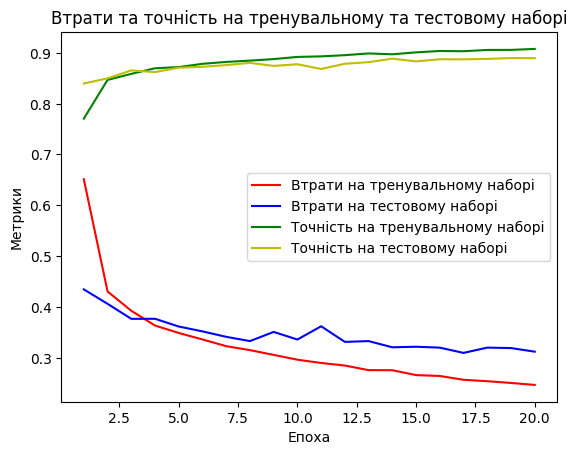

Testing value: 50
Epoch 1/50
469/469 [==============================] - 3s 5ms/step - loss: 0.6586 - accuracy: 0.7677 - val_loss: 0.4479 - val_accuracy: 0.8345
Epoch 2/50
469/469 [==============================] - 2s 4ms/step - loss: 0.4348 - accuracy: 0.8450 - val_loss: 0.4098 - val_accuracy: 0.8545
Epoch 3/50
469/469 [==============================] - 2s 4ms/step - loss: 0.3907 - accuracy: 0.8609 - val_loss: 0.3711 - val_accuracy: 0.8669
Epoch 4/50
469/469 [==============================] - 2s 4ms/step - loss: 0.3682 - accuracy: 0.8673 - val_loss: 0.3598 - val_accuracy: 0.8726
Epoch 5/50
469/469 [==============================] - 2s 5ms/step - loss: 0.3471 - accuracy: 0.8752 - val_loss: 0.3580 - val_accuracy: 0.8701
Epoch 6/50
469/469 [==============================] - 2s 5ms/step - loss: 0.3319 - accuracy: 0.8803 - val_loss: 0.3442 - val_accuracy: 0.8767
Epoch 7/50
469/469 [==============================] - 2s 4ms/step - loss: 0.3260 - accuracy: 0.8811 - val_loss: 0.3453 - val_accur

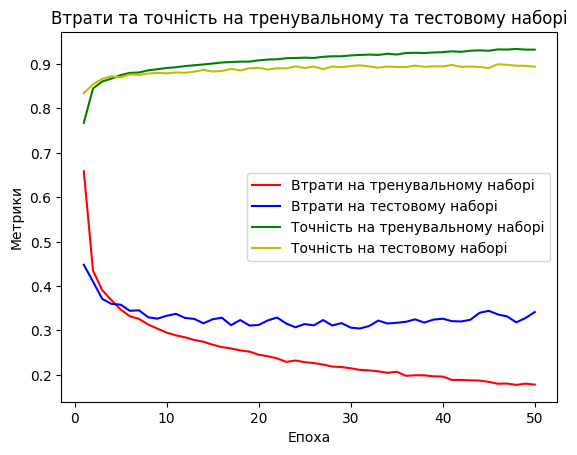

Optimal value for parameter epochs: 50, test accuracy: 0.89410001039505

Optimal parameters:
{'epochs': 50, 'batch_size': 128, 'dropout_rate': 0.2, 'loss_function': 'sparse_categorical_crossentropy', 'optimizer': 'adam', 'hidden_units': 256, 'activation': 'relu', 'metrics': ['accuracy']}
Test accuracy: 0.89410001039505


In [43]:
study_sequence = [
#                  'batch_size',
                  'dropout_rate',
                  'hidden_units',
#                  'loss_function',
#                  'optimizer',
#                  'activation',
#                  'metrics',
                  'epochs']

parameters = {
    'epochs': [10, 20, 50],
    'batch_size': [64, 128, 256],
    'dropout_rate': [0.0, 0.1, 0.2, 0.3],
    'loss_function': ['sparse_categorical_crossentropy'],
    'optimizer': ['adam'],# 'rmsprop', 'sgd'],
    'hidden_units': [64, 128, 256],
    'activation': ['relu', 'sigmoid', 'tanh'],
    'metrics': ['accuracy']
    }

optimal_parameters = {'epochs': 5,
    'batch_size': 128,
    'dropout_rate': 0.0,
    'loss_function': 'sparse_categorical_crossentropy',
    'optimizer': 'adam',
    'hidden_units': 64,
    'activation': 'relu',
    'metrics': ['accuracy']}

find_optimal_2 = find_optimal_parameters(train_images, train_labels, test_images, test_labels, parameters, optimal_parameters, study_sequence, train_model2)


Оптимальні параметри для **Моделі 2**:
```
Optimal parameters:
{'epochs': 50,
'batch_size': 128,
'dropout_rate': 0.2,
'loss_function': 'sparse_categorical_crossentropy',
'optimizer': 'adam',
'hidden_units': 256,
'activation': 'relu',
'metrics': ['accuracy']}
```
Проте точність на тестових даних недостатньо висока.
Спостерігається відсутність динаміки до покращення рівня втрат для тестових даних

Повторний пошук оптимальних параметрів для **МОДЕЛІ 2**.
Відповідно до послідовності **study_sequence**:

Searching for optimal value for parameter: dropout_rate
Testing value: 0.0
Epoch 1/5
469/469 [==============================] - 5s 6ms/step - loss: 0.7268 - accuracy: 0.7455 - val_loss: 0.4947 - val_accuracy: 0.8260
Epoch 2/5
469/469 [==============================] - 2s 4ms/step - loss: 0.4297 - accuracy: 0.8490 - val_loss: 0.4252 - val_accuracy: 0.8521
Epoch 3/5
469/469 [==============================] - 2s 4ms/step - loss: 0.3836 - accuracy: 0.8633 - val_loss: 0.4019 - val_accuracy: 0.8596
Epoch 4/5
469/469 [==============================] - 2s 4ms/step - loss: 0.3561 - accuracy: 0.8722 - val_loss: 0.3812 - val_accuracy: 0.8652
Epoch 5/5
313/313 [==============================] - 1s 2ms/step - loss: 0.3776 - accuracy: 0.8679
Точність на тестових даних: 0.867900013923645
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3170 - accuracy: 0.8842
Точність на тренувальних даних: 0.8842333555221558


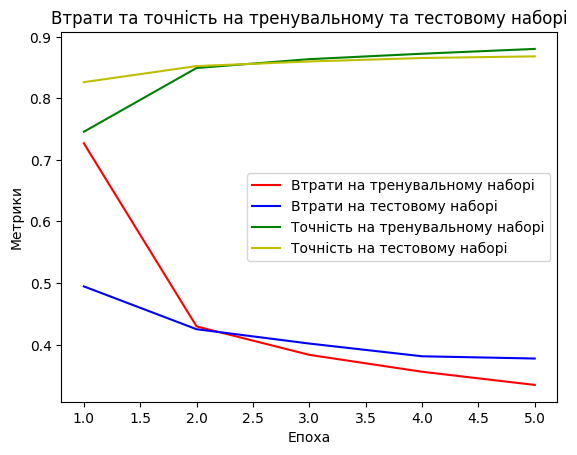

Testing value: 0.1
Epoch 1/5
469/469 [==============================] - 6s 8ms/step - loss: 0.8708 - accuracy: 0.6938 - val_loss: 0.5267 - val_accuracy: 0.7993
Epoch 2/5
469/469 [==============================] - 2s 5ms/step - loss: 0.5510 - accuracy: 0.8070 - val_loss: 0.4413 - val_accuracy: 0.8431
Epoch 3/5
469/469 [==============================] - 2s 5ms/step - loss: 0.4790 - accuracy: 0.8324 - val_loss: 0.4099 - val_accuracy: 0.8523
Epoch 4/5
469/469 [==============================] - 2s 5ms/step - loss: 0.4454 - accuracy: 0.8449 - val_loss: 0.4020 - val_accuracy: 0.8568
Epoch 5/5
313/313 [==============================] - 1s 3ms/step - loss: 0.3906 - accuracy: 0.8596
Точність на тестових даних: 0.8596000075340271
1875/1875 [==============================] - 5s 2ms/step - loss: 0.3347 - accuracy: 0.8785
Точність на тренувальних даних: 0.8784666657447815


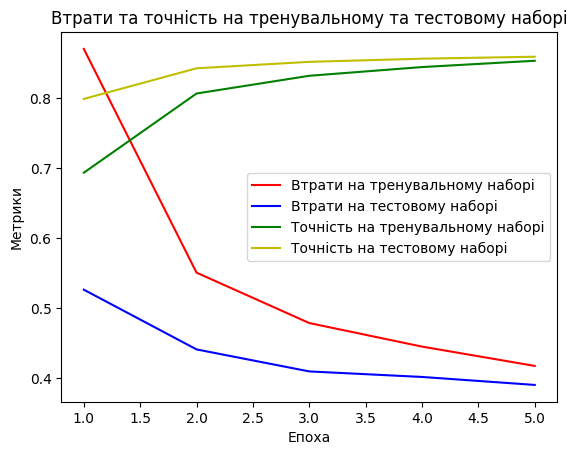

Testing value: 0.2
Epoch 1/5
469/469 [==============================] - 3s 4ms/step - loss: 1.0389 - accuracy: 0.6247 - val_loss: 0.5635 - val_accuracy: 0.7870
Epoch 2/5
469/469 [==============================] - 2s 4ms/step - loss: 0.6529 - accuracy: 0.7624 - val_loss: 0.5058 - val_accuracy: 0.8024
Epoch 3/5
469/469 [==============================] - 2s 5ms/step - loss: 0.5762 - accuracy: 0.7934 - val_loss: 0.4614 - val_accuracy: 0.8376
Epoch 4/5
469/469 [==============================] - 2s 4ms/step - loss: 0.5278 - accuracy: 0.8171 - val_loss: 0.4323 - val_accuracy: 0.8437
Epoch 5/5
313/313 [==============================] - 1s 2ms/step - loss: 0.4176 - accuracy: 0.8515
Точність на тестових даних: 0.8514999747276306
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3675 - accuracy: 0.8693
Точність на тренувальних даних: 0.8693333268165588


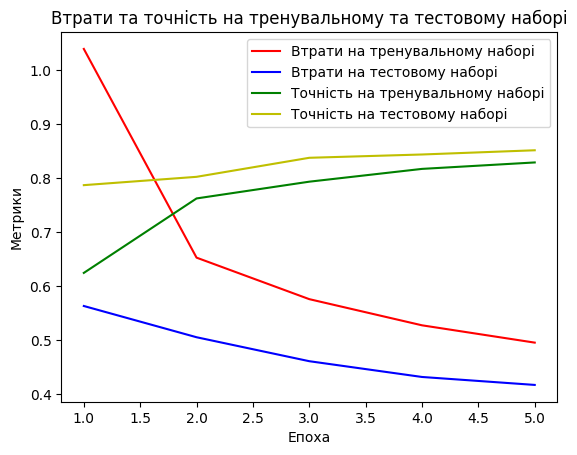

Testing value: 0.3
Epoch 1/5
469/469 [==============================] - 4s 4ms/step - loss: 1.2629 - accuracy: 0.5318 - val_loss: 0.6369 - val_accuracy: 0.7763
Epoch 2/5
469/469 [==============================] - 2s 4ms/step - loss: 0.8008 - accuracy: 0.7102 - val_loss: 0.5301 - val_accuracy: 0.8205
Epoch 3/5
469/469 [==============================] - 2s 4ms/step - loss: 0.6921 - accuracy: 0.7570 - val_loss: 0.4953 - val_accuracy: 0.8257
Epoch 4/5
469/469 [==============================] - 2s 4ms/step - loss: 0.6469 - accuracy: 0.7748 - val_loss: 0.4679 - val_accuracy: 0.8332
Epoch 5/5
313/313 [==============================] - 1s 2ms/step - loss: 0.4510 - accuracy: 0.8422
Точність на тестових даних: 0.842199981212616
1875/1875 [==============================] - 5s 3ms/step - loss: 0.4126 - accuracy: 0.8545
Точність на тренувальних даних: 0.854533314704895


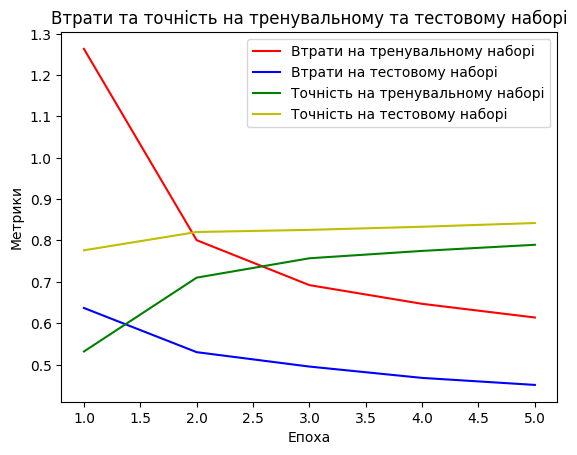

Optimal value for parameter dropout_rate: 0.0, test accuracy: 0.867900013923645

Searching for optimal value for parameter: hidden_units
Testing value: 64
Epoch 1/5
469/469 [==============================] - 3s 4ms/step - loss: 0.6959 - accuracy: 0.7678 - val_loss: 0.4784 - val_accuracy: 0.8303
Epoch 2/5
469/469 [==============================] - 2s 4ms/step - loss: 0.4257 - accuracy: 0.8504 - val_loss: 0.4225 - val_accuracy: 0.8507
Epoch 3/5
469/469 [==============================] - 2s 5ms/step - loss: 0.3839 - accuracy: 0.8624 - val_loss: 0.4111 - val_accuracy: 0.8556
Epoch 4/5
469/469 [==============================] - 2s 4ms/step - loss: 0.3535 - accuracy: 0.8728 - val_loss: 0.4061 - val_accuracy: 0.8509
Epoch 5/5
313/313 [==============================] - 1s 3ms/step - loss: 0.3889 - accuracy: 0.8586
Точність на тестових даних: 0.8586000204086304
1875/1875 [==============================] - 5s 2ms/step - loss: 0.3280 - accuracy: 0.8798
Точність на тренувальних даних: 0.8797500133

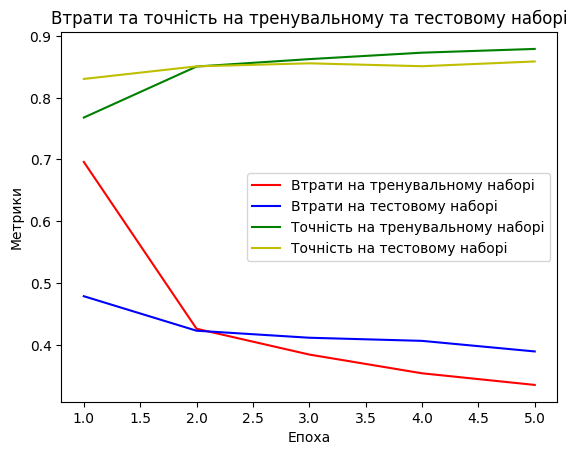

Testing value: 128
Epoch 1/5
469/469 [==============================] - 3s 4ms/step - loss: 0.5751 - accuracy: 0.8002 - val_loss: 0.5042 - val_accuracy: 0.8172
Epoch 2/5
469/469 [==============================] - 2s 4ms/step - loss: 0.3874 - accuracy: 0.8619 - val_loss: 0.4136 - val_accuracy: 0.8527
Epoch 3/5
469/469 [==============================] - 2s 4ms/step - loss: 0.3485 - accuracy: 0.8742 - val_loss: 0.3965 - val_accuracy: 0.8542
Epoch 4/5
469/469 [==============================] - 2s 4ms/step - loss: 0.3232 - accuracy: 0.8811 - val_loss: 0.3669 - val_accuracy: 0.8692
Epoch 5/5
313/313 [==============================] - 1s 4ms/step - loss: 0.3505 - accuracy: 0.8729
Точність на тестових даних: 0.8729000091552734
1875/1875 [==============================] - 5s 2ms/step - loss: 0.2811 - accuracy: 0.8961
Точність на тренувальних даних: 0.896133303642273


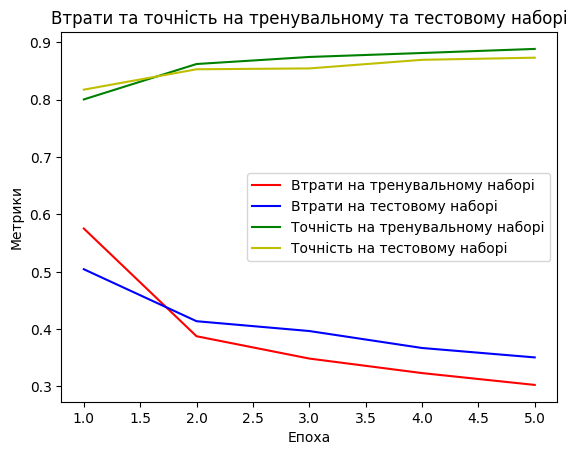

Testing value: 256
Epoch 1/5
469/469 [==============================] - 4s 6ms/step - loss: 0.5289 - accuracy: 0.8140 - val_loss: 0.4070 - val_accuracy: 0.8535
Epoch 2/5
469/469 [==============================] - 2s 5ms/step - loss: 0.3721 - accuracy: 0.8634 - val_loss: 0.3664 - val_accuracy: 0.8684
Epoch 3/5
469/469 [==============================] - 2s 4ms/step - loss: 0.3282 - accuracy: 0.8807 - val_loss: 0.3648 - val_accuracy: 0.8665
Epoch 4/5
469/469 [==============================] - 2s 4ms/step - loss: 0.3095 - accuracy: 0.8842 - val_loss: 0.3668 - val_accuracy: 0.8689
Epoch 5/5
313/313 [==============================] - 1s 2ms/step - loss: 0.3699 - accuracy: 0.8658
Точність на тестових даних: 0.8658000230789185
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2920 - accuracy: 0.8900
Точність на тренувальних даних: 0.8899833559989929


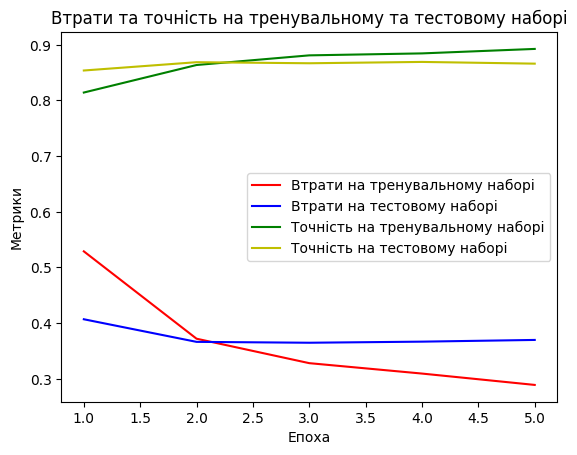

Optimal value for parameter hidden_units: 128, test accuracy: 0.8729000091552734

Searching for optimal value for parameter: optimizer
Testing value: adam
Epoch 1/5
469/469 [==============================] - 3s 5ms/step - loss: 0.5820 - accuracy: 0.7988 - val_loss: 0.4319 - val_accuracy: 0.8505
Epoch 2/5
469/469 [==============================] - 2s 4ms/step - loss: 0.3924 - accuracy: 0.8604 - val_loss: 0.3991 - val_accuracy: 0.8570
Epoch 3/5
469/469 [==============================] - 2s 4ms/step - loss: 0.3495 - accuracy: 0.8724 - val_loss: 0.3992 - val_accuracy: 0.8588
Epoch 4/5
469/469 [==============================] - 2s 4ms/step - loss: 0.3285 - accuracy: 0.8798 - val_loss: 0.3796 - val_accuracy: 0.8647
Epoch 5/5
313/313 [==============================] - 1s 4ms/step - loss: 0.3693 - accuracy: 0.8658
Точність на тестових даних: 0.8658000230789185
1875/1875 [==============================] - 5s 2ms/step - loss: 0.3023 - accuracy: 0.8867
Точність на тренувальних даних: 0.8866833448

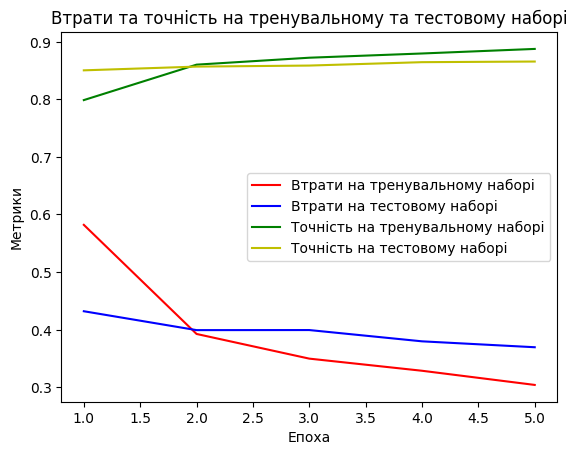

Testing value: rmsprop
Epoch 1/5
469/469 [==============================] - 3s 5ms/step - loss: 0.6003 - accuracy: 0.7841 - val_loss: 0.4528 - val_accuracy: 0.8352
Epoch 2/5
469/469 [==============================] - 2s 5ms/step - loss: 0.4088 - accuracy: 0.8498 - val_loss: 0.4002 - val_accuracy: 0.8536
Epoch 3/5
469/469 [==============================] - 2s 5ms/step - loss: 0.3615 - accuracy: 0.8675 - val_loss: 0.4138 - val_accuracy: 0.8478
Epoch 4/5
469/469 [==============================] - 2s 4ms/step - loss: 0.3338 - accuracy: 0.8773 - val_loss: 0.4345 - val_accuracy: 0.8470
Epoch 5/5
313/313 [==============================] - 1s 2ms/step - loss: 0.4157 - accuracy: 0.8486
Точність на тестових даних: 0.8485999703407288
1875/1875 [==============================] - 5s 2ms/step - loss: 0.3383 - accuracy: 0.8710
Точність на тренувальних даних: 0.8709999918937683


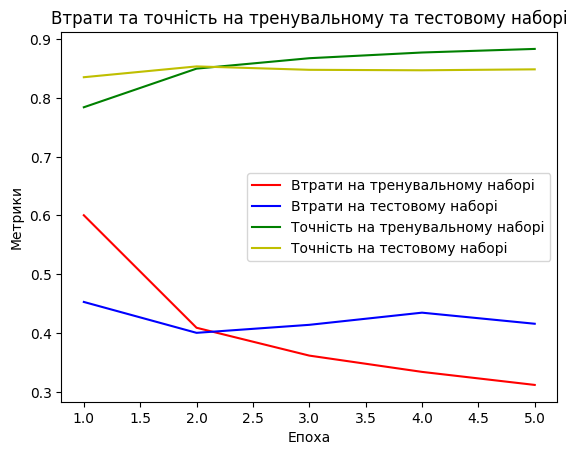

Testing value: sgd
Epoch 1/5
469/469 [==============================] - 3s 4ms/step - loss: 1.2748 - accuracy: 0.5984 - val_loss: 0.7800 - val_accuracy: 0.7376
Epoch 2/5
469/469 [==============================] - 2s 4ms/step - loss: 0.6722 - accuracy: 0.7711 - val_loss: 0.6510 - val_accuracy: 0.7634
Epoch 3/5
469/469 [==============================] - 2s 4ms/step - loss: 0.5729 - accuracy: 0.8009 - val_loss: 0.5611 - val_accuracy: 0.8042
Epoch 4/5
469/469 [==============================] - 2s 4ms/step - loss: 0.5256 - accuracy: 0.8163 - val_loss: 0.5542 - val_accuracy: 0.8015
Epoch 5/5
313/313 [==============================] - 1s 3ms/step - loss: 0.5125 - accuracy: 0.8181
Точність на тестових даних: 0.8180999755859375
1875/1875 [==============================] - 5s 3ms/step - loss: 0.4847 - accuracy: 0.8312
Точність на тренувальних даних: 0.831166684627533


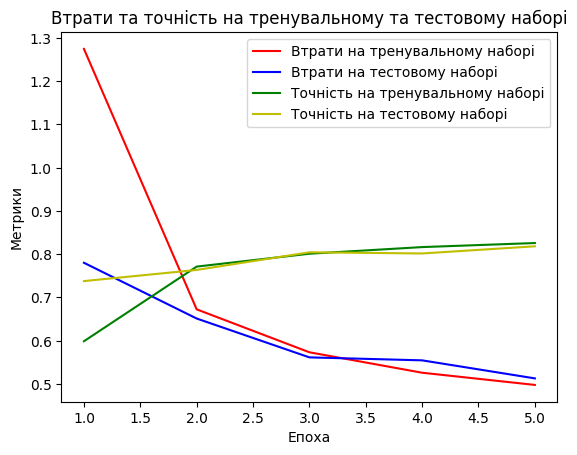

Optimal value for parameter optimizer: adam, test accuracy: 0.8729000091552734

Searching for optimal value for parameter: epochs
Testing value: 10
Epoch 1/10
469/469 [==============================] - 3s 5ms/step - loss: 0.5680 - accuracy: 0.8022 - val_loss: 0.5045 - val_accuracy: 0.8146
Epoch 2/10
469/469 [==============================] - 2s 4ms/step - loss: 0.3944 - accuracy: 0.8580 - val_loss: 0.4024 - val_accuracy: 0.8561
Epoch 3/10
469/469 [==============================] - 2s 5ms/step - loss: 0.3537 - accuracy: 0.8709 - val_loss: 0.3869 - val_accuracy: 0.8589
Epoch 4/10
469/469 [==============================] - 2s 4ms/step - loss: 0.3273 - accuracy: 0.8801 - val_loss: 0.3836 - val_accuracy: 0.8623
Epoch 5/10
469/469 [==============================] - 2s 4ms/step - loss: 0.3057 - accuracy: 0.8878 - val_loss: 0.3925 - val_accuracy: 0.8579
Epoch 6/10
469/469 [==============================] - 2s 4ms/step - loss: 0.2906 - accuracy: 0.8931 - val_loss: 0.3863 - val_accuracy: 0.8603


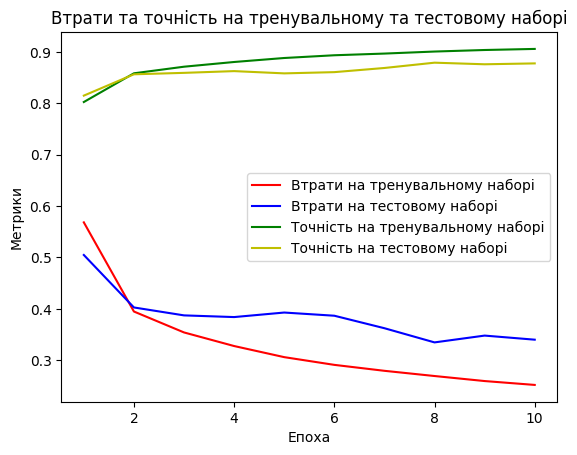

Testing value: 20
Epoch 1/20
469/469 [==============================] - 4s 5ms/step - loss: 0.5642 - accuracy: 0.8020 - val_loss: 0.4971 - val_accuracy: 0.8115
Epoch 2/20
469/469 [==============================] - 2s 4ms/step - loss: 0.3902 - accuracy: 0.8599 - val_loss: 0.4104 - val_accuracy: 0.8497
Epoch 3/20
469/469 [==============================] - 2s 4ms/step - loss: 0.3457 - accuracy: 0.8743 - val_loss: 0.4219 - val_accuracy: 0.8444
Epoch 4/20
469/469 [==============================] - 2s 4ms/step - loss: 0.3212 - accuracy: 0.8820 - val_loss: 0.3494 - val_accuracy: 0.8742
Epoch 5/20
469/469 [==============================] - 2s 4ms/step - loss: 0.3016 - accuracy: 0.8875 - val_loss: 0.3700 - val_accuracy: 0.8699
Epoch 6/20
469/469 [==============================] - 2s 5ms/step - loss: 0.2892 - accuracy: 0.8934 - val_loss: 0.3466 - val_accuracy: 0.8737
Epoch 7/20
469/469 [==============================] - 2s 4ms/step - loss: 0.2758 - accuracy: 0.8976 - val_loss: 0.3314 - val_accur

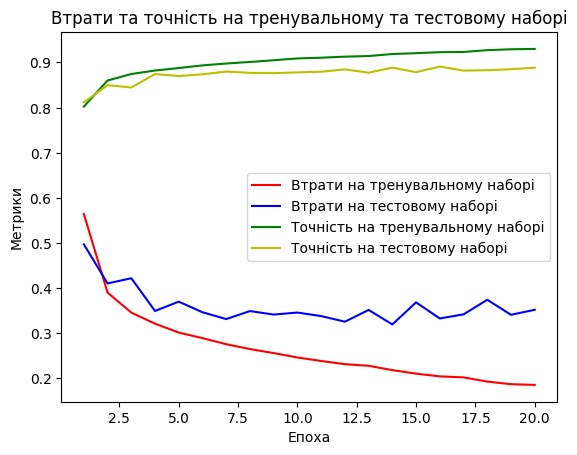

Testing value: 50
Epoch 1/50
469/469 [==============================] - 3s 4ms/step - loss: 0.5594 - accuracy: 0.8046 - val_loss: 0.4610 - val_accuracy: 0.8370
Epoch 2/50
469/469 [==============================] - 2s 4ms/step - loss: 0.3929 - accuracy: 0.8593 - val_loss: 0.3918 - val_accuracy: 0.8625
Epoch 3/50
469/469 [==============================] - 2s 4ms/step - loss: 0.3509 - accuracy: 0.8736 - val_loss: 0.3722 - val_accuracy: 0.8661
Epoch 4/50
469/469 [==============================] - 3s 6ms/step - loss: 0.3291 - accuracy: 0.8813 - val_loss: 0.3725 - val_accuracy: 0.8650
Epoch 5/50
469/469 [==============================] - 2s 4ms/step - loss: 0.3062 - accuracy: 0.8883 - val_loss: 0.3638 - val_accuracy: 0.8673
Epoch 6/50
469/469 [==============================] - 2s 4ms/step - loss: 0.2947 - accuracy: 0.8915 - val_loss: 0.3555 - val_accuracy: 0.8724
Epoch 7/50
469/469 [==============================] - 2s 4ms/step - loss: 0.2821 - accuracy: 0.8954 - val_loss: 0.3590 - val_accur

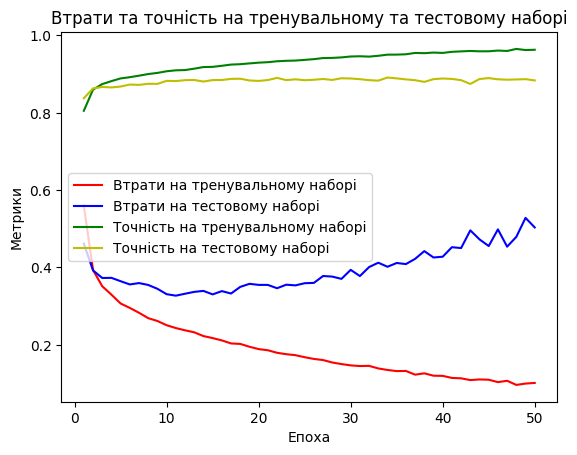

Optimal value for parameter epochs: 20, test accuracy: 0.8884000182151794

Optimal parameters:
{'epochs': 20, 'batch_size': 128, 'dropout_rate': 0.0, 'loss_function': 'sparse_categorical_crossentropy', 'optimizer': 'adam', 'hidden_units': 128, 'activation': 'relu', 'metrics': ['accuracy']}
Test accuracy: 0.8884000182151794


In [8]:
study_sequence = [
#                  'batch_size',
                  'dropout_rate',
                  'hidden_units',
#                  'loss_function',
                  'optimizer',
#                  'activation',
#                  'metrics',
                  'epochs']

parameters = {
    'epochs': [10, 20, 50],
    'batch_size': [64, 128, 256],
    'dropout_rate': [0.0, 0.1, 0.2, 0.3],
    'loss_function': ['sparse_categorical_crossentropy'],
    'optimizer': ['adam', 'rmsprop', 'sgd'],
    'hidden_units': [64, 128, 256],
    'activation': ['relu', 'sigmoid', 'tanh'],
    'metrics': ['accuracy']
    }

optimal_parameters = {'epochs': 5,
    'batch_size': 128,
    'dropout_rate': 0.0,
    'loss_function': 'sparse_categorical_crossentropy',
    'optimizer': 'adam',
    'hidden_units': 64,
    'activation': 'relu',
    'metrics': ['accuracy']}

find_optimal_3 = find_optimal_parameters(train_images, train_labels, test_images, test_labels, parameters, optimal_parameters, study_sequence, train_model2)


```
Optimal parameters:
{'epochs': 20, 'batch_size': 128, 'dropout_rate': 0.0, 'loss_function': 'sparse_categorical_crossentropy', 'optimizer': 'adam', 'hidden_units': 128, 'activation': 'relu', 'metrics': ['accuracy']}
Test accuracy: 0.8884000182151794
```



Обрано іншу послідовність навчання:
**для find_optimal_5:**

1. 'optimizer'
2. 'dropout_rate'

Searching for optimal value for parameter: optimizer
Testing value: adam
Epoch 1/20
469/469 [==============================] - 3s 4ms/step - loss: 0.5133 - accuracy: 0.8197 - val_loss: 0.4043 - val_accuracy: 0.8585
Epoch 2/20
469/469 [==============================] - 3s 6ms/step - loss: 0.3723 - accuracy: 0.8647 - val_loss: 0.3790 - val_accuracy: 0.8648
Epoch 3/20
469/469 [==============================] - 2s 4ms/step - loss: 0.3318 - accuracy: 0.8777 - val_loss: 0.3911 - val_accuracy: 0.8568
Epoch 4/20
469/469 [==============================] - 2s 4ms/step - loss: 0.3044 - accuracy: 0.8866 - val_loss: 0.3899 - val_accuracy: 0.8667
Epoch 5/20
469/469 [==============================] - 2s 4ms/step - loss: 0.2875 - accuracy: 0.8933 - val_loss: 0.3472 - val_accuracy: 0.8734
Epoch 6/20
469/469 [==============================] - 2s 4ms/step - loss: 0.2738 - accuracy: 0.8980 - val_loss: 0.3321 - val_accuracy: 0.8823
Epoch 7/20
469/469 [==============================] - 2s 4ms/step - loss: 0

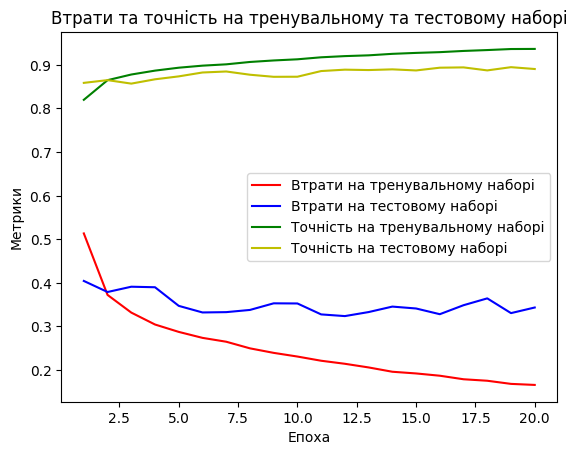

Testing value: rmsprop
Epoch 1/20
469/469 [==============================] - 3s 5ms/step - loss: 0.5829 - accuracy: 0.7879 - val_loss: 0.4194 - val_accuracy: 0.8451
Epoch 2/20
469/469 [==============================] - 2s 5ms/step - loss: 0.3921 - accuracy: 0.8544 - val_loss: 0.4001 - val_accuracy: 0.8531
Epoch 3/20
469/469 [==============================] - 3s 5ms/step - loss: 0.3486 - accuracy: 0.8716 - val_loss: 0.3767 - val_accuracy: 0.8630
Epoch 4/20
469/469 [==============================] - 2s 5ms/step - loss: 0.3215 - accuracy: 0.8806 - val_loss: 0.3661 - val_accuracy: 0.8653
Epoch 5/20
469/469 [==============================] - 2s 5ms/step - loss: 0.2989 - accuracy: 0.8882 - val_loss: 0.3542 - val_accuracy: 0.8712
Epoch 6/20
469/469 [==============================] - 2s 4ms/step - loss: 0.2843 - accuracy: 0.8935 - val_loss: 0.3574 - val_accuracy: 0.8722
Epoch 7/20
469/469 [==============================] - 2s 4ms/step - loss: 0.2711 - accuracy: 0.8990 - val_loss: 0.3445 - val_

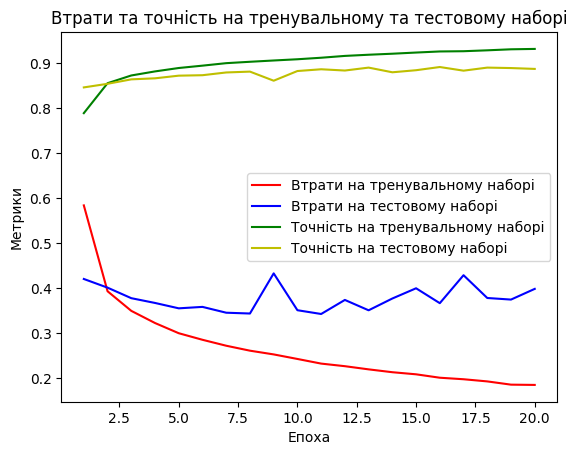

Testing value: sgd
Epoch 1/20
469/469 [==============================] - 3s 5ms/step - loss: 1.0796 - accuracy: 0.6729 - val_loss: 0.7177 - val_accuracy: 0.7528
Epoch 2/20
469/469 [==============================] - 2s 4ms/step - loss: 0.6170 - accuracy: 0.7915 - val_loss: 0.5886 - val_accuracy: 0.7955
Epoch 3/20
469/469 [==============================] - 2s 5ms/step - loss: 0.5390 - accuracy: 0.8147 - val_loss: 0.5275 - val_accuracy: 0.8173
Epoch 4/20
469/469 [==============================] - 2s 4ms/step - loss: 0.5004 - accuracy: 0.8252 - val_loss: 0.5007 - val_accuracy: 0.8251
Epoch 5/20
469/469 [==============================] - 2s 4ms/step - loss: 0.4742 - accuracy: 0.8331 - val_loss: 0.4927 - val_accuracy: 0.8295
Epoch 6/20
469/469 [==============================] - 2s 4ms/step - loss: 0.4558 - accuracy: 0.8394 - val_loss: 0.4836 - val_accuracy: 0.8299
Epoch 7/20
469/469 [==============================] - 2s 4ms/step - loss: 0.4401 - accuracy: 0.8450 - val_loss: 0.4598 - val_accu

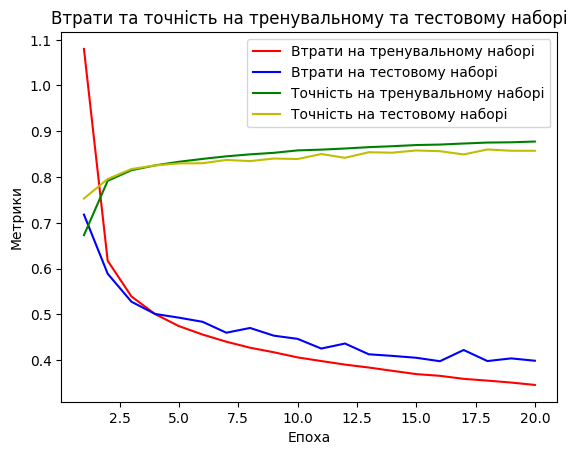

Optimal value for parameter optimizer: adam, test accuracy: 0.8902999758720398

Searching for optimal value for parameter: dropout_rate
Testing value: 0.0
Epoch 1/20
469/469 [==============================] - 3s 5ms/step - loss: 0.5270 - accuracy: 0.8155 - val_loss: 0.4454 - val_accuracy: 0.8426
Epoch 2/20
469/469 [==============================] - 2s 5ms/step - loss: 0.3693 - accuracy: 0.8662 - val_loss: 0.4015 - val_accuracy: 0.8580
Epoch 3/20
469/469 [==============================] - 3s 6ms/step - loss: 0.3335 - accuracy: 0.8781 - val_loss: 0.3800 - val_accuracy: 0.8641
Epoch 4/20
469/469 [==============================] - 2s 4ms/step - loss: 0.3071 - accuracy: 0.8874 - val_loss: 0.3770 - val_accuracy: 0.8620
Epoch 5/20
469/469 [==============================] - 2s 4ms/step - loss: 0.2876 - accuracy: 0.8947 - val_loss: 0.3345 - val_accuracy: 0.8771
Epoch 6/20
469/469 [==============================] - 2s 4ms/step - loss: 0.2748 - accuracy: 0.8978 - val_loss: 0.3251 - val_accuracy: 

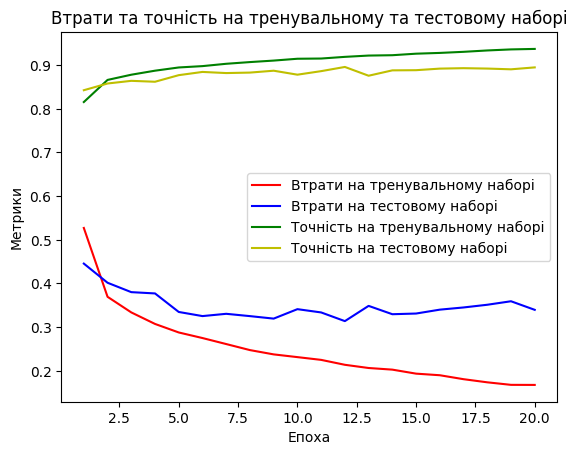

Testing value: 0.1
Epoch 1/20
469/469 [==============================] - 4s 5ms/step - loss: 0.5800 - accuracy: 0.7947 - val_loss: 0.4265 - val_accuracy: 0.8485
Epoch 2/20
469/469 [==============================] - 3s 6ms/step - loss: 0.3958 - accuracy: 0.8571 - val_loss: 0.3761 - val_accuracy: 0.8647
Epoch 3/20
469/469 [==============================] - 3s 6ms/step - loss: 0.3610 - accuracy: 0.8687 - val_loss: 0.3877 - val_accuracy: 0.8607
Epoch 4/20
469/469 [==============================] - 4s 8ms/step - loss: 0.3366 - accuracy: 0.8764 - val_loss: 0.3505 - val_accuracy: 0.8740
Epoch 5/20
469/469 [==============================] - 3s 5ms/step - loss: 0.3150 - accuracy: 0.8834 - val_loss: 0.3607 - val_accuracy: 0.8666
Epoch 6/20
469/469 [==============================] - 3s 6ms/step - loss: 0.3049 - accuracy: 0.8889 - val_loss: 0.3365 - val_accuracy: 0.8809
Epoch 7/20
469/469 [==============================] - 3s 5ms/step - loss: 0.2886 - accuracy: 0.8934 - val_loss: 0.3449 - val_accu

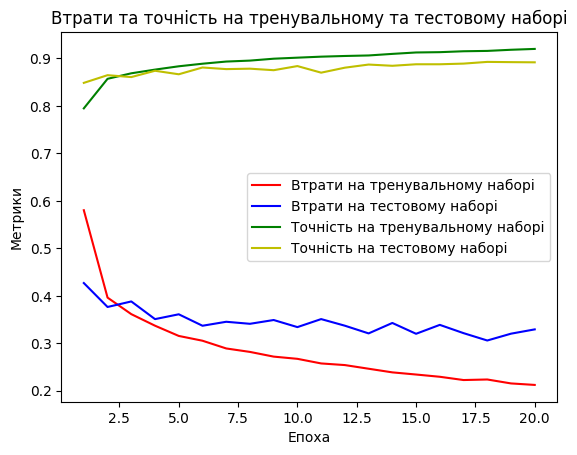

Testing value: 0.2
Epoch 1/20
469/469 [==============================] - 4s 5ms/step - loss: 0.6409 - accuracy: 0.7724 - val_loss: 0.4228 - val_accuracy: 0.8484
Epoch 2/20
469/469 [==============================] - 2s 4ms/step - loss: 0.4310 - accuracy: 0.8460 - val_loss: 0.3825 - val_accuracy: 0.8614
Epoch 3/20
469/469 [==============================] - 3s 6ms/step - loss: 0.3923 - accuracy: 0.8605 - val_loss: 0.3841 - val_accuracy: 0.8619
Epoch 4/20
469/469 [==============================] - 2s 4ms/step - loss: 0.3664 - accuracy: 0.8684 - val_loss: 0.3781 - val_accuracy: 0.8638
Epoch 5/20
469/469 [==============================] - 2s 5ms/step - loss: 0.3498 - accuracy: 0.8734 - val_loss: 0.3576 - val_accuracy: 0.8718
Epoch 6/20
469/469 [==============================] - 2s 4ms/step - loss: 0.3380 - accuracy: 0.8780 - val_loss: 0.3576 - val_accuracy: 0.8712
Epoch 7/20
469/469 [==============================] - 2s 4ms/step - loss: 0.3208 - accuracy: 0.8830 - val_loss: 0.3499 - val_accu

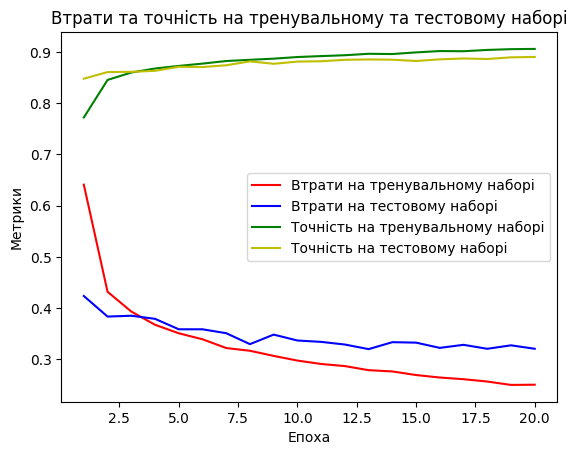

Testing value: 0.3
Epoch 1/20
469/469 [==============================] - 5s 7ms/step - loss: 0.7294 - accuracy: 0.7450 - val_loss: 0.4556 - val_accuracy: 0.8319
Epoch 2/20
469/469 [==============================] - 3s 7ms/step - loss: 0.4732 - accuracy: 0.8338 - val_loss: 0.4027 - val_accuracy: 0.8517
Epoch 3/20
469/469 [==============================] - 3s 7ms/step - loss: 0.4304 - accuracy: 0.8470 - val_loss: 0.4110 - val_accuracy: 0.8482
Epoch 4/20
469/469 [==============================] - 2s 5ms/step - loss: 0.4031 - accuracy: 0.8563 - val_loss: 0.3781 - val_accuracy: 0.8599
Epoch 5/20
469/469 [==============================] - 2s 5ms/step - loss: 0.3827 - accuracy: 0.8645 - val_loss: 0.3666 - val_accuracy: 0.8689
Epoch 6/20
469/469 [==============================] - 2s 5ms/step - loss: 0.3666 - accuracy: 0.8686 - val_loss: 0.3699 - val_accuracy: 0.8639
Epoch 7/20
469/469 [==============================] - 5s 10ms/step - loss: 0.3602 - accuracy: 0.8715 - val_loss: 0.3515 - val_acc

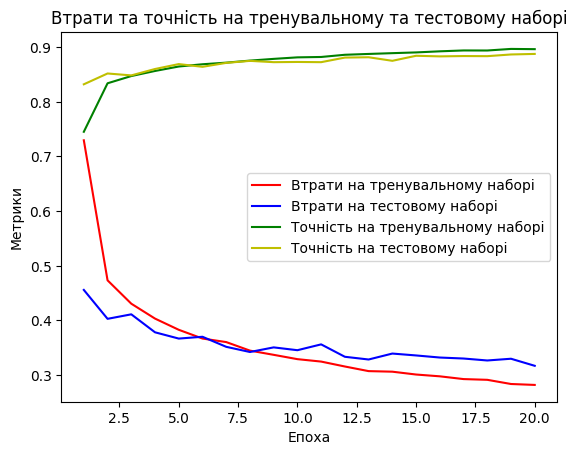

Optimal value for parameter dropout_rate: 0.0, test accuracy: 0.8949000239372253

Optimal parameters:
{'epochs': 20, 'batch_size': 128, 'dropout_rate': 0.0, 'loss_function': 'sparse_categorical_crossentropy', 'optimizer': 'adam', 'hidden_units': 256, 'activation': 'relu', 'metrics': ['accuracy']}
Test accuracy: 0.8949000239372253


In [9]:
study_sequence = [
    'optimizer',
    'dropout_rate']
    #,
#                  'hidden_units',
#                  'loss_function',

#                  'activation',
#                  'metrics',
#                  'epochs']

parameters = {
    'epochs': [10, 20, 50],
    'batch_size': [64, 128, 256],
    'dropout_rate': [0.0, 0.1, 0.2, 0.3],
    'loss_function': ['sparse_categorical_crossentropy'],
    'optimizer': ['adam', 'rmsprop', 'sgd'],
    'hidden_units': [64, 128, 256],
    'activation': ['relu', 'sigmoid', 'tanh'],
    'metrics': ['accuracy']
    }

optimal_parameters = {'epochs': 20,
    'batch_size': 128,
    'dropout_rate': 0.0,
    'loss_function': 'sparse_categorical_crossentropy',
    'optimizer': 'adam',
    'hidden_units': 256,
    'activation': 'relu',
    'metrics': ['accuracy']}

find_optimal_5 = find_optimal_parameters(train_images, train_labels, test_images, test_labels, parameters, optimal_parameters, study_sequence, train_model2)


**Вибір оптимізатора серед ['adam', 'sgd']** на інших зафіксованих параметрах при 50 епохах навчання

Searching for optimal value for parameter: optimizer
Testing value: adam
Epoch 1/50
469/469 [==============================] - 3s 5ms/step - loss: 0.5926 - accuracy: 0.7903 - val_loss: 0.4244 - val_accuracy: 0.8483
Epoch 2/50
469/469 [==============================] - 2s 5ms/step - loss: 0.4027 - accuracy: 0.8546 - val_loss: 0.3868 - val_accuracy: 0.8591
Epoch 3/50
469/469 [==============================] - 3s 6ms/step - loss: 0.3606 - accuracy: 0.8689 - val_loss: 0.3547 - val_accuracy: 0.8719
Epoch 4/50
469/469 [==============================] - 2s 5ms/step - loss: 0.3370 - accuracy: 0.8780 - val_loss: 0.3706 - val_accuracy: 0.8681
Epoch 5/50
469/469 [==============================] - 2s 4ms/step - loss: 0.3187 - accuracy: 0.8846 - val_loss: 0.3446 - val_accuracy: 0.8738
Epoch 6/50
469/469 [==============================] - 2s 4ms/step - loss: 0.3084 - accuracy: 0.8866 - val_loss: 0.3457 - val_accuracy: 0.8735
Epoch 7/50
469/469 [==============================] - 2s 4ms/step - loss: 0

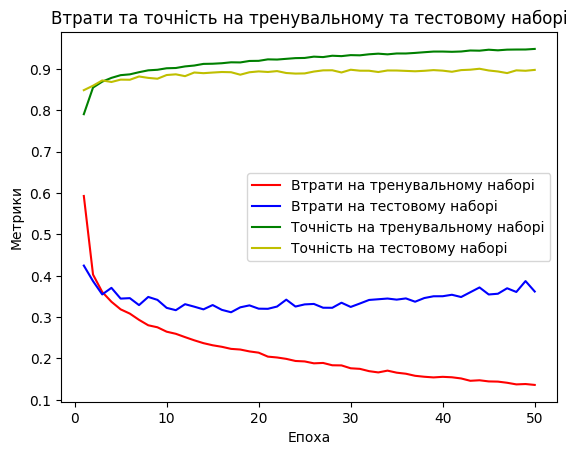

Testing value: sgd
Epoch 1/50
469/469 [==============================] - 3s 5ms/step - loss: 1.3268 - accuracy: 0.5528 - val_loss: 0.7992 - val_accuracy: 0.7252
Epoch 2/50
469/469 [==============================] - 2s 5ms/step - loss: 0.7988 - accuracy: 0.7219 - val_loss: 0.6510 - val_accuracy: 0.7795
Epoch 3/50
469/469 [==============================] - 2s 4ms/step - loss: 0.6822 - accuracy: 0.7664 - val_loss: 0.5807 - val_accuracy: 0.8040
Epoch 4/50
469/469 [==============================] - 2s 4ms/step - loss: 0.6143 - accuracy: 0.7888 - val_loss: 0.5406 - val_accuracy: 0.8147
Epoch 5/50
469/469 [==============================] - 2s 4ms/step - loss: 0.5759 - accuracy: 0.8024 - val_loss: 0.5140 - val_accuracy: 0.8205
Epoch 6/50
469/469 [==============================] - 2s 4ms/step - loss: 0.5422 - accuracy: 0.8133 - val_loss: 0.4947 - val_accuracy: 0.8292
Epoch 7/50
469/469 [==============================] - 2s 5ms/step - loss: 0.5206 - accuracy: 0.8195 - val_loss: 0.4785 - val_accu

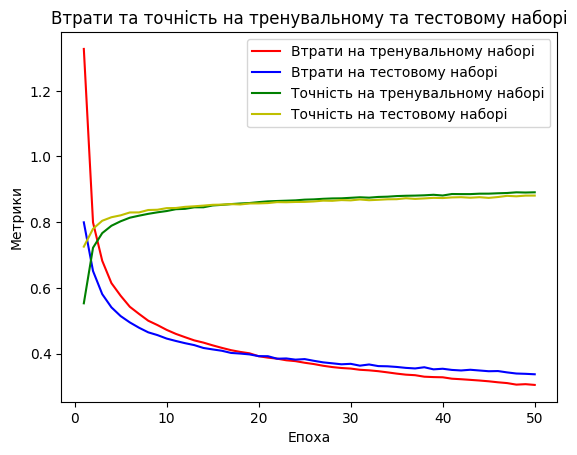

Optimal value for parameter optimizer: adam, test accuracy: 0.8973000049591064

Optimal parameters:
{'epochs': 50, 'batch_size': 128, 'dropout_rate': 0.1, 'loss_function': 'sparse_categorical_crossentropy', 'optimizer': 'adam', 'hidden_units': 256, 'activation': 'relu', 'metrics': ['accuracy']}
Test accuracy: 0.8973000049591064


In [15]:
study_sequence = [
    'optimizer']#,
#    'dropout_rate']
    #,
#                  'hidden_units',
#                  'loss_function',

#                  'activation',
#                  'metrics',
#                  'epochs']

parameters = {
    'epochs': [10, 20, 50],
    'batch_size': [64, 128, 256],
    'dropout_rate': [0.0, 0.1, 0.2, 0.3],
    'loss_function': ['sparse_categorical_crossentropy'],
    'optimizer': ['adam', 'sgd'],#'rmsprop',
    'hidden_units': [64, 128, 256],
    'activation': ['relu', 'sigmoid', 'tanh'],
    'metrics': ['accuracy']
    }

optimal_parameters = {'epochs': 50,
    'batch_size': 128,
    'dropout_rate': 0.1,
    'loss_function': 'sparse_categorical_crossentropy',
    'optimizer': 'adam',
    'hidden_units': 256,
    'activation': 'relu',
    'metrics': ['accuracy']}

find_optimal_4 = find_optimal_parameters(train_images, train_labels, test_images, test_labels, parameters, optimal_parameters, study_sequence, train_model2)


Хоча для оптимізатора **adam** спостерігається дещо вище значення точності **test accuracy: 0.8973000049591064**
а для оптимізатора **sgd** точність становить **0.8805999755859375**

Проте для останнього має місце тенденція до продовження навчання без перенавчання

Перевіримо різні значення **dropout_rate** для оптимізатора **sgd**

```
optimal_parameters = {'epochs': 50,
    'batch_size': 128,
    'dropout_rate': 0.1,
    'loss_function': 'sparse_categorical_crossentropy',
    'optimizer': 'sgd',
    'hidden_units': 256,
    'activation': 'relu',
    'metrics': ['accuracy']}
```
```
'dropout_rate': [0.0, 0.2, 0.3],
```
Кількість епох: **'epochs': 50**



Searching for optimal value for parameter: dropout_rate
Testing value: 0.0
Epoch 1/50
469/469 [==============================] - 3s 4ms/step - loss: 1.1071 - accuracy: 0.6458 - val_loss: 0.7159 - val_accuracy: 0.7432
Epoch 2/50
469/469 [==============================] - 2s 4ms/step - loss: 0.6264 - accuracy: 0.7878 - val_loss: 0.6534 - val_accuracy: 0.7527
Epoch 3/50
469/469 [==============================] - 2s 4ms/step - loss: 0.5394 - accuracy: 0.8126 - val_loss: 0.5517 - val_accuracy: 0.8023
Epoch 4/50
469/469 [==============================] - 2s 4ms/step - loss: 0.4996 - accuracy: 0.8255 - val_loss: 0.4981 - val_accuracy: 0.8248
Epoch 5/50
469/469 [==============================] - 2s 4ms/step - loss: 0.4730 - accuracy: 0.8346 - val_loss: 0.4924 - val_accuracy: 0.8283
Epoch 6/50
469/469 [==============================] - 3s 6ms/step - loss: 0.4535 - accuracy: 0.8409 - val_loss: 0.4968 - val_accuracy: 0.8213
Epoch 7/50
469/469 [==============================] - 3s 5ms/step - loss:

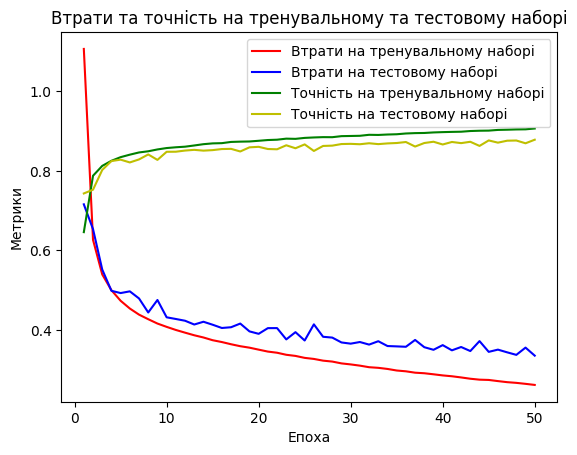

Testing value: 0.2
Epoch 1/50
469/469 [==============================] - 3s 4ms/step - loss: 1.4577 - accuracy: 0.4830 - val_loss: 0.8537 - val_accuracy: 0.7023
Epoch 2/50
469/469 [==============================] - 2s 4ms/step - loss: 0.9069 - accuracy: 0.6723 - val_loss: 0.6964 - val_accuracy: 0.7474
Epoch 3/50
469/469 [==============================] - 2s 5ms/step - loss: 0.7709 - accuracy: 0.7267 - val_loss: 0.6258 - val_accuracy: 0.7676
Epoch 4/50
469/469 [==============================] - 2s 5ms/step - loss: 0.6937 - accuracy: 0.7528 - val_loss: 0.5785 - val_accuracy: 0.7900
Epoch 5/50
469/469 [==============================] - 2s 4ms/step - loss: 0.6441 - accuracy: 0.7714 - val_loss: 0.5452 - val_accuracy: 0.8044
Epoch 6/50
469/469 [==============================] - 2s 4ms/step - loss: 0.6060 - accuracy: 0.7865 - val_loss: 0.5178 - val_accuracy: 0.8184
Epoch 7/50
469/469 [==============================] - 2s 4ms/step - loss: 0.5759 - accuracy: 0.7972 - val_loss: 0.4985 - val_accu

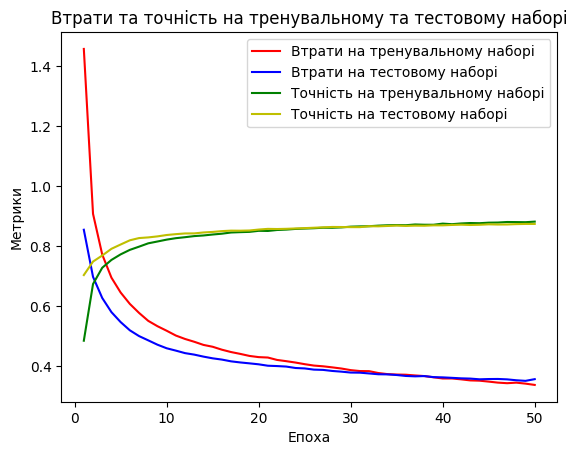

Testing value: 0.3
Epoch 1/50
469/469 [==============================] - 4s 6ms/step - loss: 1.6051 - accuracy: 0.4370 - val_loss: 0.9105 - val_accuracy: 0.6864
Epoch 2/50
469/469 [==============================] - 2s 4ms/step - loss: 1.0081 - accuracy: 0.6410 - val_loss: 0.7144 - val_accuracy: 0.7448
Epoch 3/50
469/469 [==============================] - 2s 4ms/step - loss: 0.8382 - accuracy: 0.7028 - val_loss: 0.6350 - val_accuracy: 0.7667
Epoch 4/50
469/469 [==============================] - 2s 4ms/step - loss: 0.7525 - accuracy: 0.7340 - val_loss: 0.5837 - val_accuracy: 0.7872
Epoch 5/50
469/469 [==============================] - 2s 4ms/step - loss: 0.6956 - accuracy: 0.7537 - val_loss: 0.5552 - val_accuracy: 0.7950
Epoch 6/50
469/469 [==============================] - 2s 5ms/step - loss: 0.6555 - accuracy: 0.7689 - val_loss: 0.5303 - val_accuracy: 0.8066
Epoch 7/50
469/469 [==============================] - 2s 5ms/step - loss: 0.6235 - accuracy: 0.7816 - val_loss: 0.5121 - val_accu

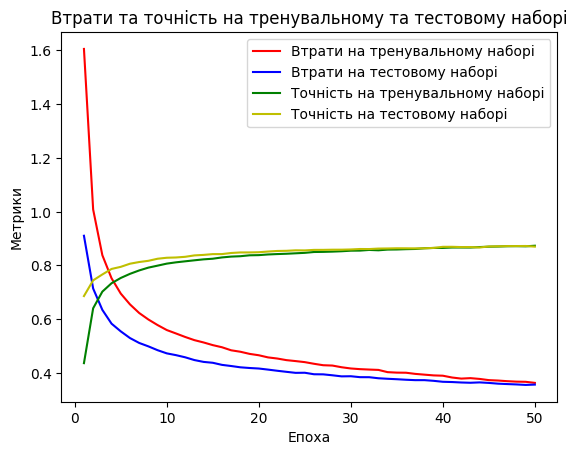

Optimal value for parameter dropout_rate: 0.0, test accuracy: 0.8784999847412109

Optimal parameters:
{'epochs': 50, 'batch_size': 128, 'dropout_rate': 0.0, 'loss_function': 'sparse_categorical_crossentropy', 'optimizer': 'sgd', 'hidden_units': 256, 'activation': 'relu', 'metrics': ['accuracy']}
Test accuracy: 0.8784999847412109


In [10]:
study_sequence = [
#    'optimizer']#,
    'dropout_rate']
    #,
#                  'hidden_units',
#                  'loss_function',

#                  'activation',
#                  'metrics',
#                  'epochs']

parameters = {
    'epochs': [10, 20, 50],
    'batch_size': [64, 128, 256],
    'dropout_rate': [0.0, 0.2, 0.3],
    'loss_function': ['sparse_categorical_crossentropy'],
    'optimizer': ['adam', 'sgd'],#'rmsprop',
    'hidden_units': [64, 128, 256],
    'activation': ['relu', 'sigmoid', 'tanh'],
    'metrics': ['accuracy']
    }

optimal_parameters = {'epochs': 50,
    'batch_size': 128,
    'dropout_rate': 0.1,
    'loss_function': 'sparse_categorical_crossentropy',
    'optimizer': 'sgd',
    'hidden_units': 256,
    'activation': 'relu',
    'metrics': ['accuracy']}

find_optimal_6 = find_optimal_parameters(train_images, train_labels, test_images, test_labels, parameters, optimal_parameters, study_sequence, train_model2)


In [ ]:
def train_model3(train_images, train_labels, test_images, test_labels, epochs=15, batch_size=32, dropout_rate=0.2,
                loss_function='sparse_categorical_crossentropy', optimizer='adam', hidden_units=128,
                activation='relu', metrics=['accuracy']):

    model = models.Sequential([
    layers.Flatten(input_shape=(28, 28, 1)),
    layers.Dense(hidden_units, activation='relu'),
    layers.Dropout(dropout_rate),
    layers.Dense(hidden_units/2, activation='relu'),  # Додатковий Dense шар
    layers.Dropout(dropout_rate),
    layers.Dense(hidden_units/4, activation='relu'),   # Додатковий Dense шар
    layers.Dropout(dropout_rate),
    layers.Dense(10, activation='softmax')
    ])


    model.compile(optimizer=optimizer,
              loss=loss_function,
              metrics=metrics)

    history = model.fit(train_images, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(test_images, test_labels))

    test_loss, test_acc = model.evaluate(test_images, test_labels)
    print('Точність на тестових даних:', test_acc)

    train_loss, train_acc = model.evaluate(train_images, train_labels)
    print('Точність на тренувальних даних:', train_acc)

    return model, history, test_acc, train_acc

Під час навчання моделі **find_optimal_3** було знайдено оптимальні параметри для **train_model2**:
```
    model = models.Sequential([
    layers.Flatten(input_shape=(28, 28, 1)),
    layers.Dense(hidden_units, activation='relu'),
    layers.Dropout(dropout_rate),
    layers.Dense(hidden_units/2, activation='relu'),
    layers.Dropout(dropout_rate),
    layers.Dense(hidden_units/4, activation='relu'),
    layers.Dropout(dropout_rate),
    layers.Dense(10, activation='softmax')
    ])


    model.compile(optimizer=optimizer,
              loss=loss_function,
              metrics=metrics)
```
**Optimal parameters:**

{'epochs': 50, 'batch_size': 128, 'dropout_rate': 0.2, 'loss_function': 'sparse_categorical_crossentropy', 'optimizer': 'adam', 'hidden_units': 256, 'activation': 'relu', 'metrics': ['accuracy']}

**Точність на тестових даних: 0.89410001039505**

**Точність на тренувальних даних: 0.949833333492279**